<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">
    Insiders Project
</h1>
</div>


## Data Dictionary


|Attribute|Description
----------|-----------
InvoiceNo| Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode| Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description| Product (item) name. Nominal.
Quantity| The quantities of each product (item) per transaction. Numeric.
InvoiceDate| Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice| Unit price. Numeric, Product price per unit in sterling.
CustomerID| Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country| Country name. Nominal, the name of the country where each customer resides.

# 0.0 Imports

In [25]:
import pandas as pd
import inflection
import GeneralUtils  as gu
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import numpy as np
import scipy.stats as st
from scipy.stats import kstest
import sweetviz

import dotenv
import datetime as dt
#
import umap.umap_ as um
from sklearn.decomposition import PCA
import sklearn.metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
import sklearn.manifold as man

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
import sklearn.mixture as mix
from scipy.cluster.hierarchy import dendrogram, ward, linkage, fcluster
import pickle
import s3fs

### Feature Engineering Functions

In [2]:
def recency_feat(df_feature_, df_feature_transaction_):

    # Recency
    diff = df_feature_.invoice_date.max() - df_feature_transaction_.groupby('customer_id').max()['invoice_date']
    recency = pd.DataFrame(diff).reset_index().rename(columns={'invoice_date': 'recency'})

    recency['recency'] = recency['recency'].dt.days

    return recency


def frequency_feat(df_feature_, df_feature_transaction_):

    # Frequency
    max_date = df_feature_.invoice_date.max()
    aux = df_feature_transaction_.groupby('customer_id').agg( max_ = ('invoice_date', 'max'), 
                                        min_ = ('invoice_date', 'min'),
                                        #days_ = ('invoice_date', lambda x: (max_date - min_date).days + 1),
                                        days_ = ('invoice_date', lambda x: (max_date - x.min()).days + 1),
                                        buy_ = ('invoice_no', 'nunique'),
                                        ).reset_index()

    aux['frequency'] = aux.buy_/aux.days_

    return aux


def total_spent_feat(df_feature_):

    # Total Spent
    df_feature_['gross_revenue'] = df_feature_.quantity * df_feature_.unit_price

    monetary = df_feature_.groupby('customer_id').sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'total_spent'})
    df_feature_ = df_feature_.merge((monetary), how='left', on='customer_id')

    return monetary

In [3]:
def transactions_feat(df_features_):

    # Transactions
    transactions = df_features_.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'transactions'})

    return transactions


def avg_ticket_feat(df_features_):

    # Average Ticket
    avg_ticket = df_features_.groupby(['customer_id', 'invoice_no']).sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'avg_ticket'}).groupby('customer_id').mean(numeric_only=True).reset_index()
   
    return avg_ticket


def product_variety_feat(df_features_):

    # Product Variety
    product_variety = df_features_.groupby('customer_id').nunique()[['description']].reset_index().rename(columns={'description': 'product_variety'})
    
    return product_variety


def avg_basket_feat(df_features_):

    # Average Basket Size 
    avg_basket = df_features_[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).sum()\
                                                                                                                    .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                    .reset_index().rename(columns={'quantity': 'avg_basket'})

    return avg_basket


def avg_basket_variety_feat(df_features_): 

    # Average Basket Variety Size
    avg_basket_var = df_features_[['customer_id', 'invoice_no', 'stock_code']].groupby(['customer_id', 'invoice_no']).nunique()\
                                                                                                                    .reset_index().groupby('customer_id').mean(numeric_only=True)\
                                                                                                                    .reset_index().rename(columns={'stock_code': 'avg_basket_variety'})
  
    return avg_basket_var

In [4]:
def cancellations_feat(df_features_): 

    cancellations = df_features_[['customer_id', 'quantity']].groupby('customer_id').apply(lambda c: c.abs().sum())[['quantity']].reset_index().rename(columns={'quantity': 'number_of_cancellations'})

    return cancellations


def quantity_feat(df_features_): 

    # Total Quantity
    quantity = df_features_.groupby('customer_id').sum(numeric_only=True).quantity.reset_index().rename(columns={'quantity': 'total_quantity'})

    return quantity

cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#fae7af")]
}
index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: #021e37; font-weight:normal;"
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #021e37; color: white;"
}
facecolor='#021e37'

In [5]:
plt.style.use('seaborn-v0_8')
#sns.set_style('darkgrid')

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">
Load Data
</h1>


</div>

In [6]:
#secret = dotenv.dotenv_values('../.env')['SECRET_KEY']
#key = dotenv.dotenv_values('../.env')['ACCESS_KEY']
#
#path_s3 = 's3://insider-data-bucket/'
#df_raw = pd.read_csv(path_s3 +  'Ecommerce.csv', 
#                     encoding='ISO-8859-1',
#                     storage_options={'key': key,
#                                      'secret': secret})
#

In [7]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

In [8]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">1.0. Data Description</h1>


</div>

In [9]:
df_description = df_raw.drop('Unnamed: 8', axis=1)

In [10]:
df_description.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Renaming Columns

In [11]:
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity','InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

df_description.columns = new_cols

In [12]:
df_description['description'] = df_description['description'].str.lower()

In [13]:
df_description.sort_values(['invoice_date', 'description'])

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
143414,548701,23007,spaceboy baby gift set,1,1-Apr-17,16.95,17629.0,United Kingdom
143694,548711,22906,12 message cards with envelopes,2,1-Apr-17,1.65,18116.0,United Kingdom
144000,548715,22906,12 message cards with envelopes,6,1-Apr-17,1.65,17758.0,United Kingdom
143573,548708,84461,12 pink hen+chicks in basket,1,1-Apr-17,2.55,13269.0,United Kingdom
144035,548715,21457,2 picture book eggs easter ducks,6,1-Apr-17,1.25,17758.0,United Kingdom
...,...,...,...,...,...,...,...,...
335644,566290,84836,zinc metal heart decoration,2,9-Sep-17,1.25,14456.0,United Kingdom
335748,566291,84836,zinc metal heart decoration,3,9-Sep-17,1.25,12965.0,United Kingdom
335588,566290,23153,zinc sweetheart wire letter rack,2,9-Sep-17,3.75,14456.0,United Kingdom
334150,566233,23145,zinc t-light holder star large,12,9-Sep-17,0.95,12635.0,Germany


## 1.2. Data Dimension

In [14]:
print(f'Number of Rows: {df_description.shape[0]}')
print(f'Number of Columnss: {df_description.shape[1]}')

Number of Rows: 541909
Number of Columnss: 8


## 1.3. Data Types & Missing Values

In [15]:
gu.sum_table(df_description)

,Name,dtypes,Uniques,Missing,Missing %
0,invoice_no,object,25900,0,0.00
1,stock_code,object,4070,0,0.00
2,description,object,4206,1454,0.27
3,quantity,int64,722,0,0.00
4,invoice_date,object,305,0,0.00
5,unit_price,float64,1630,0,0.00
6,customer_id,float64,4372,135080,24.93
7,country,object,38,0,0.00


## 1.4.  Handling Missing Values

Checking if there are invoice numbers of elements with missing customer ID in other part of the dataset, so we can fill the missing values.

In [16]:
df_missing = df_description.query('customer_id.isnull()')
df_no_missing = df_description.query('~customer_id.isnull()')

inv_no_missing_customers = df_missing.invoice_no.unique()
stock_code_missing_customers = df_no_missing.stock_code.unique()

df_description.loc[df_description.invoice_date.isin(inv_no_missing_customers)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


**I will assign a custom customer ID to each unique invoice number with a missing customer ID. A unique custom customer ID will be assigned for each unique invoice number.**

Issue: by doing this, these new customers' IDs will only have one transaction, but this might be better than removing all this data.

In [17]:
missing_invoice_no = df_missing[['invoice_no']].drop_duplicates()
missing_invoice_no['customer_id'] = np.arange(19000, 19000+len(missing_invoice_no))
df_description = df_description.merge(missing_invoice_no, on='invoice_no', how='left')
df_description['customer_id'] = df_description['customer_id_x'].combine_first(df_description['customer_id_y'])
df_clean = df_description.drop(columns=['customer_id_x', 'customer_id_y'])

## 1.5. Fixing Data Types

In [18]:
df_clean.invoice_date = pd.to_datetime(df_clean.invoice_date)
df_clean.customer_id = df_clean.customer_id.astype(int)

In [19]:
df_clean.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.6. Descriptive Statistics

### 1.6.1 Numerical Attributes

In [20]:
num_att = df_clean.select_dtypes(include=['float64', 'int64'])
cat_att = df_clean.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

In [21]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,min,max,range,mean,median,var,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,47559.391409,218.081158,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,9362.469164,96.759853,186.506972,59005.719097


In [22]:
df_clean.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997])[['quantity', 'unit_price']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,99.7%,max
quantity,541909.0,9.552250,218.081158,-80995.00,-2.00,1.00,1.00,1.00,3.00,12.00,24.00,29.00,100.0,240.00,80995.0
unit_price,541909.0,4.611114,96.759853,-11062.06,0.19,0.42,0.63,0.85,2.08,4.95,7.95,9.95,18.0,39.95,38970.0


In [23]:
df_clean.sort_values('quantity').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
540422,C581484,23843,"paper craft , little birdie",-80995,2017-12-07,2.08,United Kingdom,16446
61624,C541433,23166,medium ceramic top storage jar,-74215,2017-01-16,1.04,United Kingdom,12346
225529,556690,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20914
225530,556691,23005,printing smudges/thrown away,-9600,2017-06-12,0.00,United Kingdom,20915
4287,C536757,84347,rotating silver angels t-light hldr,-9360,2016-11-30,0.03,United Kingdom,15838


There are some weird values in this dataset. We know that 'C' stands for cancellation in the invoice code, so we expect to see a negative quantity in these instances. But we can observe some samples that aren't cancellations with a negative quantity. We will further examine this issue in the filter variables section.

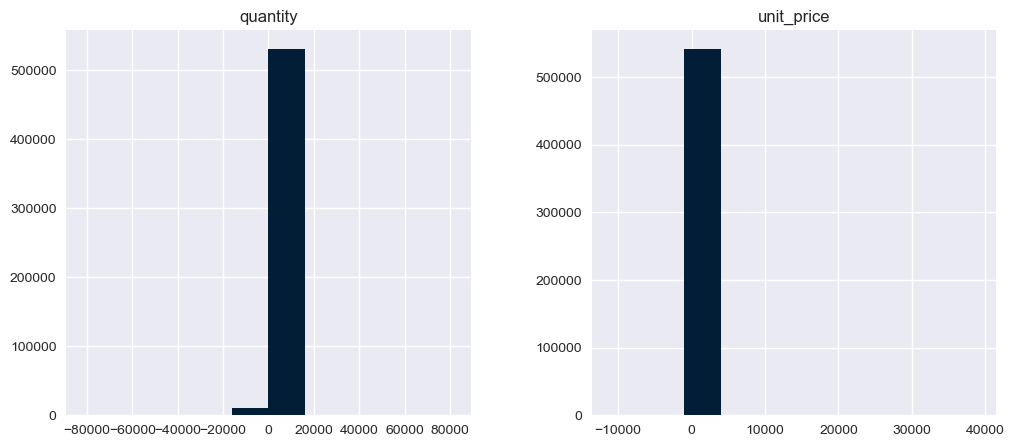

In [24]:
df_clean.drop(columns=['invoice_date', 'customer_id']).hist(figsize=(12, 5), facecolor=facecolor);

### <font color='red'> 1.6.2  Further Analysis needed </font>

Quantity with negative values -> What to do with cancellations.

Unit price < 0 -> error? remove these values?

Unit Price very close to 0?

### 1.6.3 Categorical Attributes

**Invoice Number with at least one string**

In [25]:
# df_description.inoice_no.astype(int)
letter_invoices = df_clean.loc[df_description.invoice_no.str.contains('C')]

print('Total Number of Cancellation invoices:', len(letter_invoices))
print('Total Number of Negative quantites:', len(letter_invoices.query('quantity < 0')))

Total Number of Cancellation invoices: 9288
Total Number of Negative quantites: 9288


**Stock codes with at least one string**

In [26]:
df_clean.loc[~df_clean.stock_code.str.isdigit()].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,white hanging heart t-light holder,6,2016-11-29,2.55,United Kingdom,17850
2,536365,84406B,cream cupid hearts coat hanger,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,knitted union flag hot water bottle,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,red woolly hottie white heart.,6,2016-11-29,3.39,United Kingdom,17850
45,536370,POST,postage,3,2016-11-29,18.00,France,12583


**Stock codes that are only strings**

In [27]:
df_clean.loc[df_clean.stock_code.str.isalpha()].stock_code.value_counts()
# Remove stovk_code in [POST, M, D, DOT, CRUK, PADS, AMAZONFEE ,CRUK, DCGSSGIRL, DCGSSBOY, PADS, B, m]

POST         1256
DOT           710
M             571
D              77
S              63
AMAZONFEE      34
CRUK           16
DCGSSGIRL      13
DCGSSBOY       11
PADS            4
B               3
m               1
Name: stock_code, dtype: int64

**Countries**

In [28]:
df_clean.groupby('country').nunique()[['customer_id']].reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">2.0. Variables Filtering</h1>

</div>

In [29]:
df_filter = df_clean.copy()
columns = ['invoice_no', 'quantity', 'invoice_date', 'unit_price', 'customer_id']

## 2.1. Numerical

In [30]:
df_filter.query("(quantity <= 0 & invoice_no.str.isdigit())").sort_values('quantity').description.unique()[:40]#.head()

array(['printing smudges/thrown away', 'throw away',
       'unsaleable, destroyed.', nan, 'wrongly marked. 23343 in box',
       'check', 'incorrect stock entry.', 'mouldy, thrown away.',
       "thrown away-can't sell", 'thrown away-rusty', '?missing',
       'mouldy, unsaleable.', 'damages wax', 'damages/credits from asos.',
       'mystery! only ever imported 1800', 'damaged', 'thrown away',
       'given away', 'incorrectly credited c550456 see 47',
       'reverse previous adjustment', 'sold as set on dotcom and amazon',
       '? sold as sets?', 'lost??', 'thrown away.', 'damaged stock', '?',
       'lost', 'wrongly coded 20713', 'damages', 'wrongly sold sets',
       'code mix up? 84930', 'wet rusty', 'missing',
       'wrongly coded-23343', 'sold as set/6 by dotcom',
       'possible damages or lost?', 'wet pallet', 'sold in set?',
       'dotcom set', '??'], dtype=object)

By the description of those items, it seems like they are some mistakes or an issue with the product. Since these instances don't represent actual sales, we will remove them from the dataset.

In [31]:
df_filter = df_filter.query("~(quantity <= 0 & invoice_no.str.isdigit())")

**Unit prices very close to zero**

In [32]:
df_filter.query('unit_price >= 0 and unit_price < 0.004').sort_values('unit_price').isnull().sum()

invoice_no        0
stock_code        0
description     592
quantity          0
invoice_date      0
unit_price        0
country           0
customer_id       0
dtype: int64

Half of the instances don't have a description, which makes it harder to define what these instances mean. Therefore, they will be removed (unit price < 0.004).

In [33]:
df_filter = df_filter.query('unit_price >= 0.004')

## 2.2. Categorical

In [34]:
# removing stock_codes that are only letters
df_filter = df_filter.query("~stock_code.isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])")

# removing European Community and Unspecified
df_filter = df_filter.query("~country.isin(['European Community', 'Unspecified'])")

#country_dict = {'EIRE': 'Ireland', 'RSA': 'South Africa', 'USA': 'United States', 'Channel Islands': 'United Kingdom'}

#countries_to_modify = ['USA', 'Channel Islands', 'RSA', 'EIRE']

#df_filter.country = df_filter.country.apply(lambda x: country_dict[x] if x in countries_to_modify else x)

In [35]:
# description
print(f'Removed data: {1 - (df_filter.shape[0]/df_clean.shape[0]):.3%}')
print(f'Number of Elements Removed: {df_clean.shape[0] - df_filter.shape[0]}')

Removed data: 1.064%
Number of Elements Removed: 5765


In [36]:
df_filter.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

In [37]:
print('Number of rows Cancelation:', df_filter.query("quantity < 0 or invoice_no.str.contains('C')").shape[0])
print('Number of rows Transaction:', df_filter.query('quantity > 0').shape[0])

Number of rows Cancelation: 8730
Number of rows Transaction: 527414


<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">3.0. Feature Engineering</h1>


</div>

In [38]:
df_feature = df_filter.copy()
df_feature_cancellation = df_filter.query("quantity < 0 or invoice_no.str.contains('C')").copy()
df_feature_transaction = df_filter.query('quantity > 0').copy()

**Recency, Frequency and Monetary**

In [39]:
#  Number of days since the last purchase
recency = recency_feat(df_feature, df_feature_transaction)

# Number of unique purchases/days since first date in the dataset.
frequency = frequency_feat(df_feature, df_feature_transaction)

# Total Spent
monetary = total_spent_feat(df_feature)

**Number of transactions, Variety, Average Ticket and Average Basket Size**

In [40]:
# Number of purchases
transactions = transactions_feat(df_feature)

# Average purchases value
avg_ticket = avg_ticket_feat(df_feature)

# Number Unique products.
product_variety = product_variety_feat(df_feature_transaction)

# Average basket size
avg_basket = avg_basket_feat(df_feature)

# Average number of unique products per purchase
avg_basket_variety = avg_basket_variety_feat(df_feature_transaction)

**Average Recency, Total Cancelltions, Quantity** - <font color='red'>Average Recency Removed</font>

In [41]:
# Number of cancellation
cancellations = cancellations_feat(df_feature_cancellation)

# Total Quantity
quantity = quantity_feat(df_feature)

In [42]:
df_feature_new = df_feature.copy().merge(recency, how='left', on='customer_id')\
.drop_duplicates('customer_id')\
.merge(frequency[['customer_id', 'frequency']], how='left', on='customer_id')\
.merge(monetary, how='left', on='customer_id')\
.merge(transactions, how='left', on='customer_id')\
.merge(avg_ticket, how='left', on='customer_id')\
.merge(product_variety, how='left', on='customer_id')\
.merge(avg_basket, how='left', on='customer_id')\
.merge(avg_basket_variety, how='left', on='customer_id')\
.merge(cancellations, how='left', on='customer_id')\
.merge(quantity, how='left', on='customer_id')


In [43]:
df_feature_new.isnull().sum()

invoice_no                    0
stock_code                    0
description                   0
quantity                      0
invoice_date                  0
unit_price                    0
country                       0
customer_id                   0
gross_revenue                 0
recency                      91
frequency                    91
total_spent                   0
transactions                  0
avg_ticket                    0
product_variety              91
avg_basket                    0
avg_basket_variety           91
number_of_cancellations    4190
total_quantity                0
dtype: int64

Some customers only have cancellations, they need to be removed.

In [44]:
columns = ['customer_id', 'recency', 'frequency', 'total_spent', 'transactions', 'total_quantity', 'avg_ticket', 'product_variety', 'avg_basket', 'avg_basket_variety', 'number_of_cancellations']
df_customers = df_feature_new.copy()[columns]
df_customers.head()

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
0,17850,372.0,0.090909,5288.63,35,1693,151.103714,21.0,48.371429,8.735294,40.0
1,13047,56.0,0.024064,3089.10,16,1355,193.068750,105.0,84.687500,19.000000,35.0
2,12583,2.0,0.040107,6629.34,17,4978,389.961176,116.0,292.823529,15.466667,50.0
3,13748,95.0,0.013369,948.25,5,439,189.650000,24.0,87.800000,5.600000,NaN
4,15100,333.0,0.008021,635.10,6,58,105.850000,1.0,9.666667,1.000000,22.0


In [45]:
df_customers.isnull().sum()

customer_id                   0
recency                      91
frequency                    91
total_spent                   0
transactions                  0
total_quantity                0
avg_ticket                    0
product_variety              91
avg_basket                    0
avg_basket_variety           91
number_of_cancellations    4190
dtype: int64

The number of cancelations with null values are customers with no cancellations.

I want to focus on customers who have made purchases. Therefore I will remove those with a negative monetary value, which may mean they have more canceled orders than purchases.

In [46]:
# fill null values for number of cancellations
df_customers['number_of_cancellations'] = df_customers['number_of_cancellations'].fillna(0)

# removing customers with a total spent <= 0.
df_customers_clean = df_customers.query('(total_spent > 0)')
print('Items Removed:', df_customers.shape[0] - df_customers_clean.shape[0])

Items Removed: 101


In [47]:
df_customers_clean.isnull().sum()

customer_id                0
recency                    0
frequency                  0
total_spent                0
transactions               0
total_quantity             0
avg_ticket                 0
product_variety            0
avg_basket                 0
avg_basket_variety         0
number_of_cancellations    0
dtype: int64

In [48]:
#df_customers_clean.to_csv('../data/processed/df_customers_clean.cvs')

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


<div style = 'background-color:#021e37'>

<font align="center" color='white'>
    <h1/>4.0. Exploratory Data Analysis
</h1>
</font>

</div>

## 4.1 Univariate Analysis

In [49]:
df_eda = pd.read_csv('../data/processed/df_customers_clean.csv')

In [51]:
#my_report = sweetviz.analyze(df_eda)
#my_report.show_html(layout='widescreen')

### 4.1.1. Total Spent

In [52]:
df_eda.sort_values('total_spent', ascending=False).head(10)

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
992,14646,1.0,0.202817,278778.02,73,196556,3818.876986,717.0,2692.547945,28.611111,288.0
481,18102,0.0,0.163043,259657.30,60,64124,4327.621667,162.0,1068.733333,7.183333,0.0
424,17450,8.0,0.125000,189735.53,49,69041,3872.153673,125.0,1409.000000,7.304348,952.0
65,14911,1.0,0.532086,133007.13,243,76931,547.354444,1815.0,316.588477,28.482412,3332.0
1121,12415,24.0,0.059172,123638.18,24,76946,5151.590833,450.0,3206.083333,35.650000,427.0
186,14156,9.0,0.147849,114505.32,65,57026,1761.620308,730.0,877.323077,25.327273,859.0
15,17511,2.0,0.082888,88138.20,45,63014,1958.626667,465.0,1400.311111,31.064516,1535.0
931,16684,4.0,0.077994,65920.12,30,49391,2197.337333,121.0,1646.366667,9.892857,864.0
35,13694,3.0,0.133690,62924.10,57,61808,1103.931579,369.0,1084.350877,11.360000,1504.0
8,15311,0.0,0.243316,59419.34,118,37720,503.553729,576.0,319.661017,25.901099,474.0


These customers with very high monetary values don't seem to be outliers (errors), just excellent customers.

### 4.1.2. Product Variety

In [53]:
df_eda.sort_values('product_variety', ascending=False).head()

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
65,14911,1.0,0.532086,133007.13,243,76931,547.354444,1815.0,316.588477,28.482412,3332.0
46,12748,0.0,0.550802,30486.53,217,23976,140.490922,1776.0,110.488479,20.733010,1535.0
67,17841,1.0,0.331551,40333.22,169,22850,238.658107,1344.0,135.207101,60.233871,203.0
4328,14096,4.0,0.166667,53258.43,17,16336,3132.848824,1128.0,960.941176,297.882353,0.0
5173,22221,39.0,0.025000,14855.53,1,5197,14855.530000,1107.0,5197.000000,1109.000000,0.0


### 4.1.3. Average Basket

In [54]:
df_eda.sort_values('avg_basket').head(5)

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
4872,12607,60.0,0.016393,3.552714e-15,2,0,0.000000e+00,101.0,0.0,101.0,1228.0
4937,12454,56.0,0.017544,5.684342e-14,2,0,2.273737e-13,15.0,0.0,15.0,1006.0
3065,13762,218.0,0.004566,3.552714e-15,2,0,2.842171e-14,7.0,0.0,7.0,272.0
5614,12558,7.0,0.125000,1.065814e-14,2,0,0.000000e+00,11.0,0.0,11.0,196.0
5314,18274,30.0,0.032258,1.776357e-15,2,0,0.000000e+00,11.0,0.0,11.0,88.0


In [55]:
df_eda.sort_values('avg_basket', ascending=False).head(5)

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
5275,22312,32.0,0.030303,52940.94,1,14149,52940.94,101.0,14149.0,101.0,0.0
5388,22383,25.0,0.038462,50653.91,1,13956,50653.91,99.0,13956.0,99.0,0.0
4473,18251,87.0,0.011364,4314.72,1,7824,4314.72,16.0,7824.0,16.0,0.0
2584,20055,255.0,0.003906,21389.60,1,5963,21389.60,138.0,5963.0,138.0,0.0
5173,22221,39.0,0.025000,14855.53,1,5197,14855.53,1107.0,5197.0,1109.0,0.0


### 4.1.4. Number of Cancellations

In [56]:
df_eda.sort_values('number_of_cancellations', ascending=False).head(5)

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
3278,16446,0.0,0.009709,2.90,3,2,0.966667,3.0,0.666667,1.500000,80995.0
158,15838,11.0,0.051630,33362.28,20,9008,1668.114000,54.0,450.400000,8.789474,9360.0
1231,15749,235.0,0.009009,21535.90,4,9014,5383.975000,5.0,2253.500000,3.333333,9014.0
12,16029,38.0,0.165775,58193.85,66,32203,881.725000,44.0,487.924242,3.854839,8004.0
946,12931,21.0,0.041899,33544.81,19,23577,1765.516316,30.0,1240.894737,5.266667,4427.0


In [57]:
df_eda.query('number_of_cancellations > 1000 & (transactions < 10 or total_quantity < 1000)')

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
1057,14533,24.0,0.019830,1.812620e+03,9,2777,2.014022e+02,53.0,308.555556,8.857143,1242.0
1231,15749,235.0,0.009009,2.153590e+04,4,9014,5.383975e+03,5.0,2253.500000,3.333333,9014.0
1683,16938,8.0,0.012945,1.903130e+03,5,1025,3.806260e+02,215.0,205.000000,57.750000,1515.0
3278,16446,0.0,0.009709,2.900000e+00,3,2,9.666667e-01,3.0,0.666667,1.500000,80995.0
4872,12607,60.0,0.016393,3.552714e-15,2,0,0.000000e+00,101.0,0.000000,101.000000,1228.0
4937,12454,56.0,0.017544,5.684342e-14,2,0,2.273737e-13,15.0,0.000000,15.000000,1006.0


I will remove customer 16446 since this is the only one with very few quantities and transactions with an extreme value for the number of cancellations, which indicates that some error occurred.

### 4.1.7 Quantity

In [58]:
df_eda.sort_values('total_quantity', ascending=False).head()

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
992,14646,1.0,0.202817,278778.02,73,196556,3818.876986,717.0,2692.547945,28.611111,288.0
1121,12415,24.0,0.059172,123638.18,24,76946,5151.590833,450.0,3206.083333,35.650000,427.0
65,14911,1.0,0.532086,133007.13,243,76931,547.354444,1815.0,316.588477,28.482412,3332.0
424,17450,8.0,0.125000,189735.53,49,69041,3872.153673,125.0,1409.000000,7.304348,952.0
481,18102,0.0,0.163043,259657.30,60,64124,4327.621667,162.0,1068.733333,7.183333,0.0


In [59]:
df_eda.query('total_quantity == 0')

,customer_id,recency,frequency,total_spent,transactions,total_quantity,avg_ticket,product_variety,avg_basket,avg_basket_variety,number_of_cancellations
3065,13762,218.0,0.004566,3.552714e-15,2,0,2.842171e-14,7.0,0.0,7.0,272.0
4872,12607,60.0,0.016393,3.552714e-15,2,0,0.000000e+00,101.0,0.0,101.0,1228.0
4937,12454,56.0,0.017544,5.684342e-14,2,0,2.273737e-13,15.0,0.0,15.0,1006.0
5314,18274,30.0,0.032258,1.776357e-15,2,0,0.000000e+00,11.0,0.0,11.0,88.0
5614,12558,7.0,0.125000,1.065814e-14,2,0,0.000000e+00,11.0,0.0,11.0,196.0


Notes


**Recency:** Average Variability (good distribution for clustering)

**Frequency:** Low Variability (Highly concentrated distibution)

**Monetary:** High Variability (Highly concentrated in low values)

**Transactions:** Average Variability (Highly concentrated in low values)

**Average Ticket:** High Variability (Highly concentrated in low values)

**Product Variety:** High Variability (Highly concentrated but more sparse than the other features)

**Average Basket Size:** High Variability (Highly concentrated in low values)

**Average Basket Variety:** Average Variability (High concentration in low values, but more evenly distributed)

**Number of Cancellations:** High Variability (Highly concentrated in low values with a huge outlier)

**Removing bad users**

In [60]:
df_eda = df_eda.query('~(customer_id == 16446) & (total_quantity!=0)').copy()
df_eda.shape[0]

5680

## 4.3 Bivariate Analysis

In [62]:
fig = px.scatter_matrix(df_eda.drop(['customer_id'], axis=1), color_discrete_sequence=[facecolor])
fig.update_layout(width=2000, height=1250, font={'size': 8})
fig.show()

e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [30]:
#df_eda.to_csv('../data/processed/df_clean.csv', index=False)

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">5.0. Data Preparation</h1>


</div>

In [7]:
df_prep = pd.read_csv('../data/processed/df_clean.csv')

## 5.1 Defining the rescale method.

#### Rule of thumb

Rescale x Standardization
1. Normal distribution without outliers -> Standard Scaler
2. Normal distribution with Outliers -> Robust Scaler
3. Not normal distribution -> Min Max Scaler

**Normality Tests**

QQ Plot -> Quantile Plot 

KS Test -> Kolmogorov Smirnoff (Hypothesis Test)


**Outlier detection**

Box Plot (2.5 IQ)

Z-Score > 3
Z-Score < -3


Now, We will test for normality using the Kolmogorov-Smirnov Test and using Q-Q Plot.

In [8]:
std = Pipeline([('standard', pp.StandardScaler())])
minmax = Pipeline([('minmax', pp.MinMaxScaler())])
robust = Pipeline([('robust', pp.RobustScaler())])


cols = ['recency', 'frequency', 'total_spent', 'total_quantity', 'transactions', 'avg_ticket', 'product_variety', 'avg_basket', 'number_of_cancellations']
pass_cols = ['customer_id'] 

preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('minmax', minmax, cols)])
#std_preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('standard', std, cols)])

In [9]:
tests = {}
for col in df_prep.drop(columns=['customer_id']).columns.to_list():
    stat, p = kstest(df_prep[col], cdf='norm')
    if p < 0.05:
        result = 'Not Normal'
    else:
        result = 'Normal'
    tests[col] = p, result
pd.DataFrame(tests).T.rename(columns={0: 'p-value', 1: 'Result'})

,p-value,Result
recency,0.0,Not Normal
frequency,0.0,Not Normal
total_spent,0.0,Not Normal
transactions,0.0,Not Normal
total_quantity,0.0,Not Normal
avg_ticket,0.0,Not Normal
product_variety,0.0,Not Normal
avg_basket,0.0,Not Normal
avg_basket_variety,0.0,Not Normal
number_of_cancellations,0.0,Not Normal


## Q-Q Plot

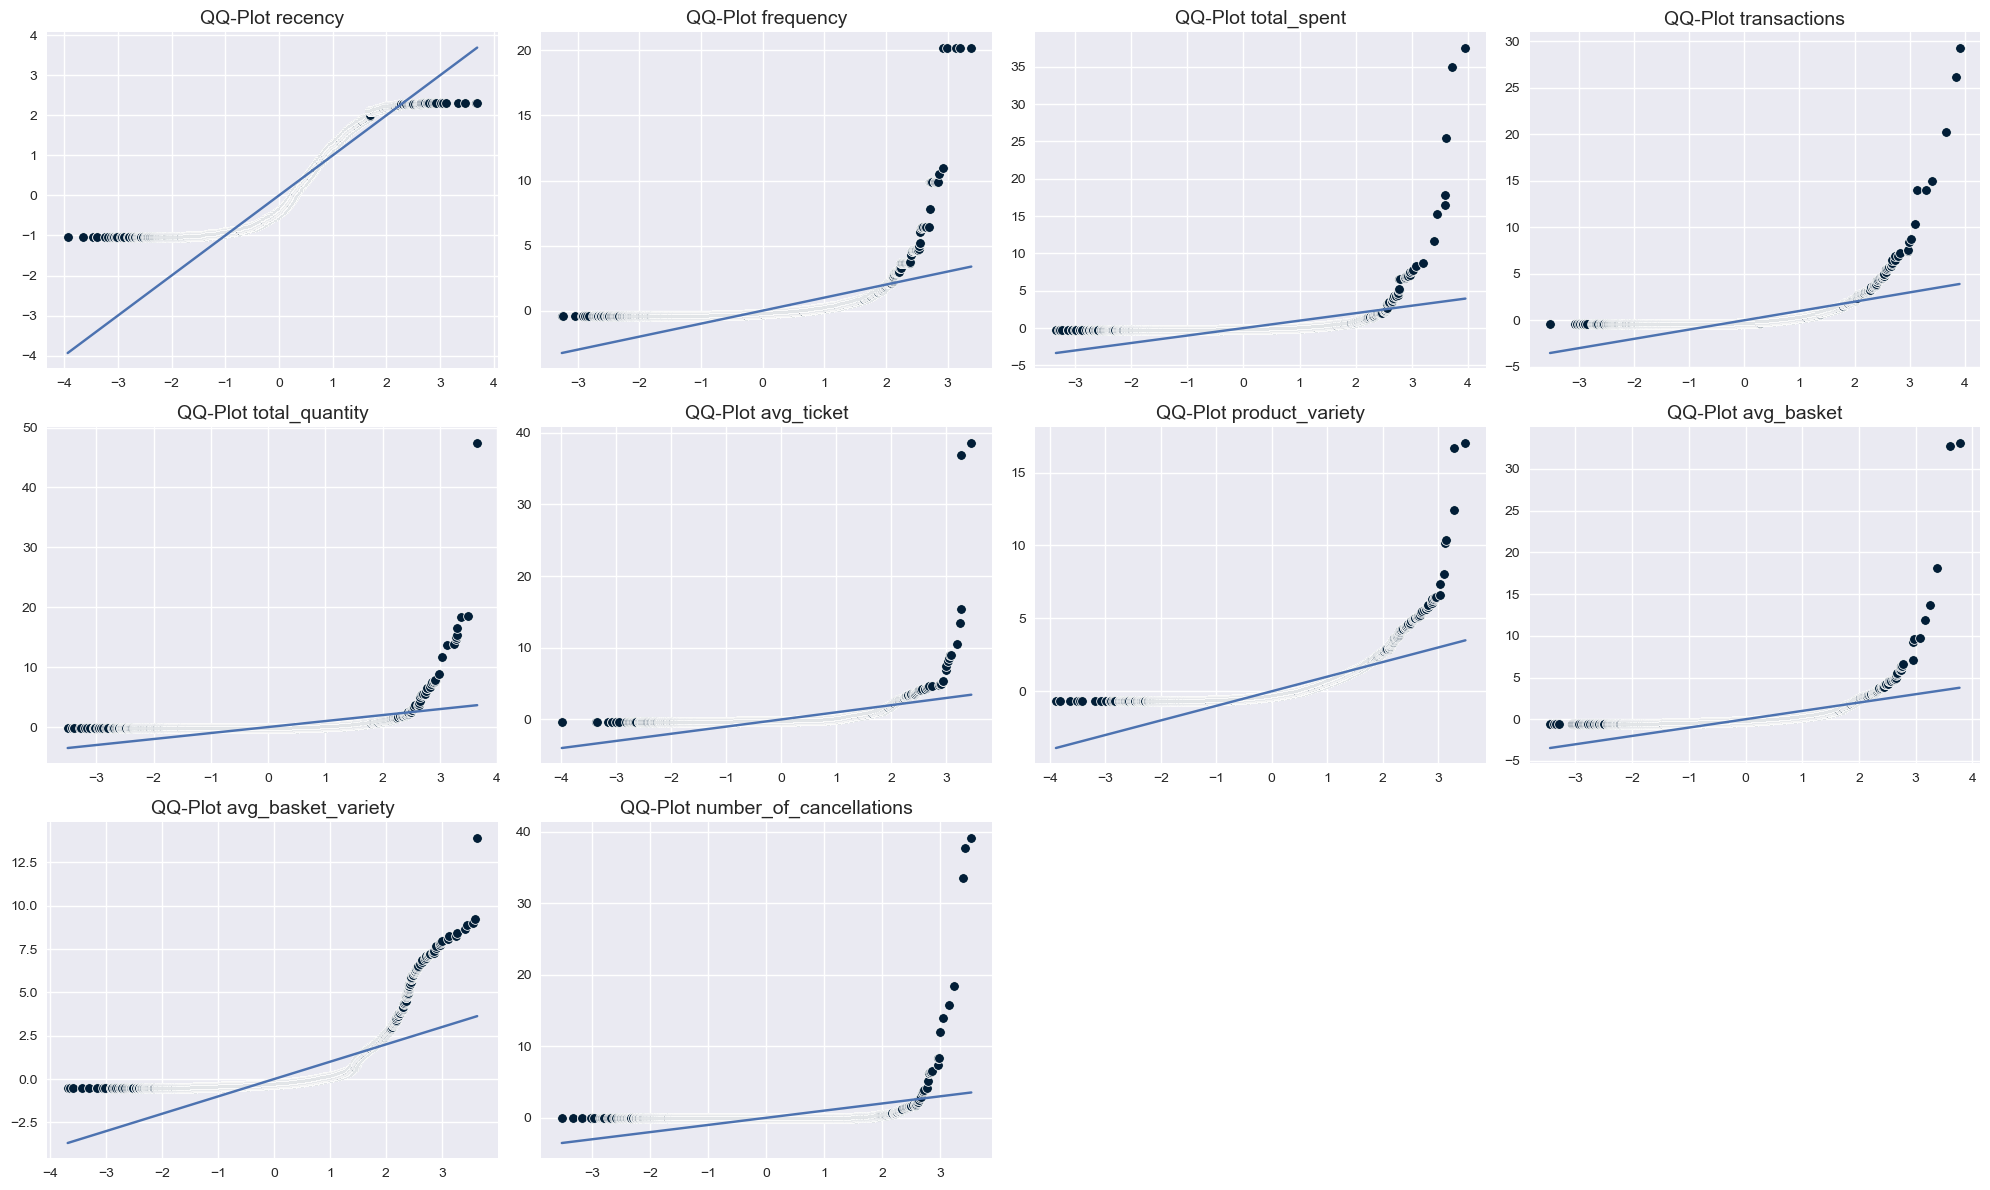

In [10]:
k = 1
columns = df_prep.drop(columns=['customer_id']).columns
n_plots = len(columns)
ncols = 4
nrows = int(np.ceil(n_plots/ncols))
plt.figure(figsize=(20, 12))
for feature in columns:

    plt.subplot(nrows, ncols, k)
    plt.title(f'QQ-Plot {feature}', fontsize=14)
    gu.qq_plot(feature, df_prep, std)
    plt.tight_layout()
    k += 1
    
    #print(k)

None of the features follows a normal distribution.

**Using Min Max Scaler for all features.**

In [11]:
#df_prep_scaled
df_prep_scaled = pd.DataFrame(preprocess.fit_transform(df_prep))
cols = np.concatenate((pass_cols, cols), axis=0)
df_prep_scaled.columns = cols

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">6.0. Feature Selection</h1>

</div>

Now, we will select the features that will make more sense, in a business perspective, when we analyze the clusters' metrics.

In [12]:
# avg_basket
# avg_recency
# items
# Transaction

columns_selected = ['customer_id', 'recency', 'frequency', 'total_spent', 'total_quantity', 'number_of_cancellations']

In [13]:
df_fselect = df_prep.copy()[columns_selected]
df_fselect_sc = df_prep_scaled.copy()[columns_selected]

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">7.0. Embedding Spaces</h1>


</div>

In this Section, we will visualize the data in a lower dimensional space with three different dimensionality reduction techniques:

Principal Component Analysis (PCA)

t-Distributed Stochastic Neighbor

UMAP (Uniform Manifold Approximation and Projection)

Tree-based embedding and UMAP for dimensionality reduction.

In [14]:
df_embed = df_fselect.drop(columns=['customer_id']).copy()

df_embed_sc = df_fselect_sc.drop(columns=['customer_id']).copy()

## 7.1. PCA

This method consits of rotating the dataset in a way such that the rotated features (principal components) are statiscally uncorrelated. Then a subset of the new features are selected according to their importance to explain the data.

obs: PCA aligns the principal components with the directions of maximum variance in the original data.

In [15]:
pca = PCA(n_components=df_embed_sc.shape[1])
pca.fit(df_embed_sc)
df_pca = pca.transform(df_embed_sc)
print(f'Original shape: {str(df_embed_sc.shape)}')
print(f'Reduced shape: {str(df_pca.shape)}')
print(f'{sum(pca.explained_variance_ratio_):.3f}')

Original shape: (5680, 5)
Reduced shape: (5680, 5)
1.000


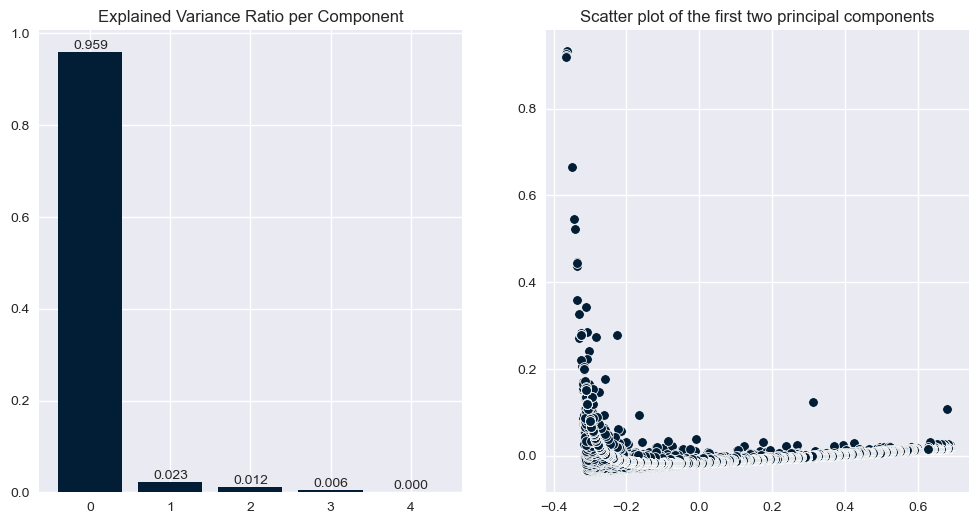

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), facecolor=facecolor)
x_pos = np.arange(pca.n_components_)
bar = ax[0].bar(x=x_pos, height=pca.explained_variance_ratio_, color=facecolor)
ax[0].set_title('Explained Variance Ratio per Component')

ax[0].bar_label(bar, fmt='%.3f');


sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], ax=ax[1], color=facecolor)
plt.title('Scatter plot of the first two principal components')
plt.show()


## 7.2. T-SNE

This is a dimensionality reduction technique that is most commonly used for visualizing high-dimensional data in a lower-dimensional space 2D or 3D.

obs:

    - t-SNE adapts its notion of 'distance' to regional density variations in the data, so you cannot see relative sizes of clusters in a t-SNE plot. So be careful when analyzing the t-sne results and clustering on it.
    
    - We might need to fine-tune some of the hyperparameters.

    https://distill.pub/2016/misread-tsne/

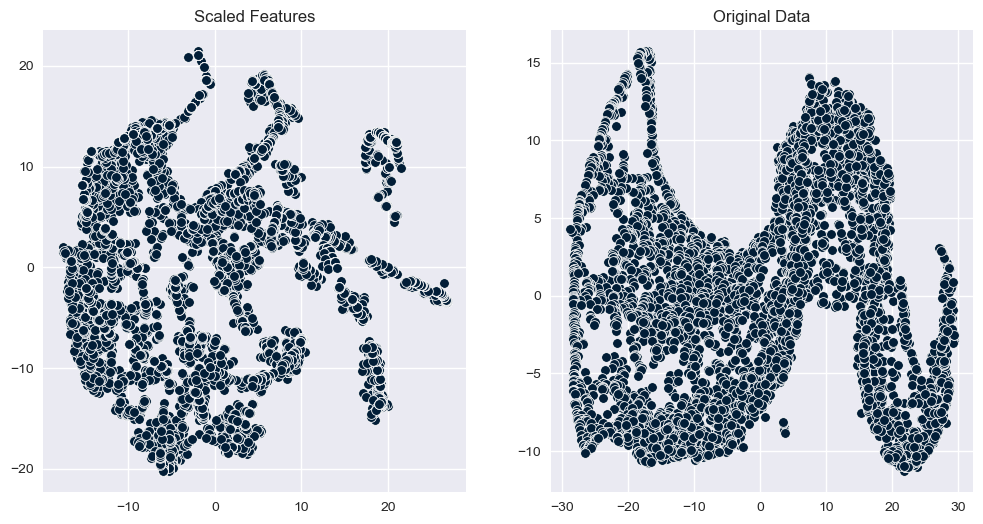

In [17]:
tsne = man.TSNE(perplexity=40, n_iter=1500, random_state=42, n_components=3)

df_tsne_sc = tsne.fit_transform(df_embed_sc)
df_tsne = tsne.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_tsne_sc[:, 0], y=df_tsne_sc[:, 1], color=facecolor)
plt.title('Scaled Features')

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], color=facecolor)
plt.title('Original Data')
plt.show()

## 7.3. UMAP

It is a dimension reduction technique constructed from a theoretical framework based in Riemannian geometry and algebraic topology. It can be used for visualization similarly to t-SNE.

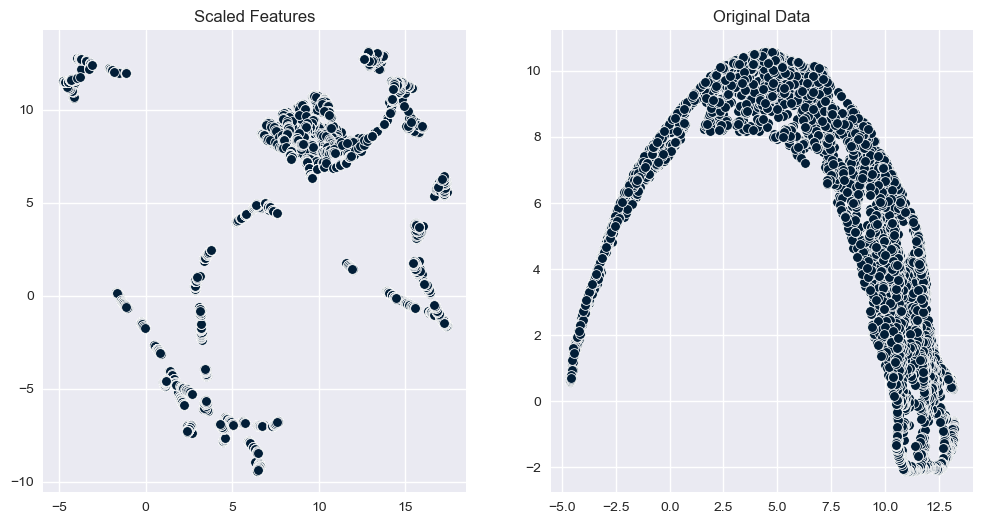

In [18]:
umap = um.UMAP(n_neighbors=40, random_state=42, n_components=3, n_epochs=500)

df_umap_sc = umap.fit_transform(df_embed_sc)
df_umap = umap.fit_transform(df_embed)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_umap_sc[:, 0], y=df_umap_sc[:, 1], color=facecolor)
plt.title('Scaled Features')

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], color=facecolor)
plt.title('Original Data')
plt.show()


## 7.4. Tree-Based Embedding

In this section, we will create a tree-based space using the total spent as the target variable and then use the UMAP dimension reduction method. To make this tree-based space, I use the ´apply´ method that returns the leaf indices from each tree, resulting in a data frame with n columns, where n is the number of estimators in the random forest.

With this technique, we lose explainability about how the clusters are formed, but it might help the model find them. And for this project, we are not interested in explaining why a customer belongs or not to a specific group.

In [19]:
X = df_embed.drop(columns='total_spent')
y = df_embed['total_spent']

# model
#rf = RandomForestRegressor(n_estimators=100, random_state=42)
#rf.fit(X, y)

rf = pickle.load(open('../models/rf_model.pkl', 'rb'))

# Aplying the tree structure in the training set (Leafs)
df_leaf = pd.DataFrame(rf.apply(X)) 


In [20]:
#pickle.dump(rf, open('../models/rf_model.pkl', 'wb'))
#fs = s3fs.S3FileSystem(anon=False, key=key, secret=secret)
#pickle.dump(rf, fs.open('s3://insider-data-bucket/rf_model.pkl', 'wb'))

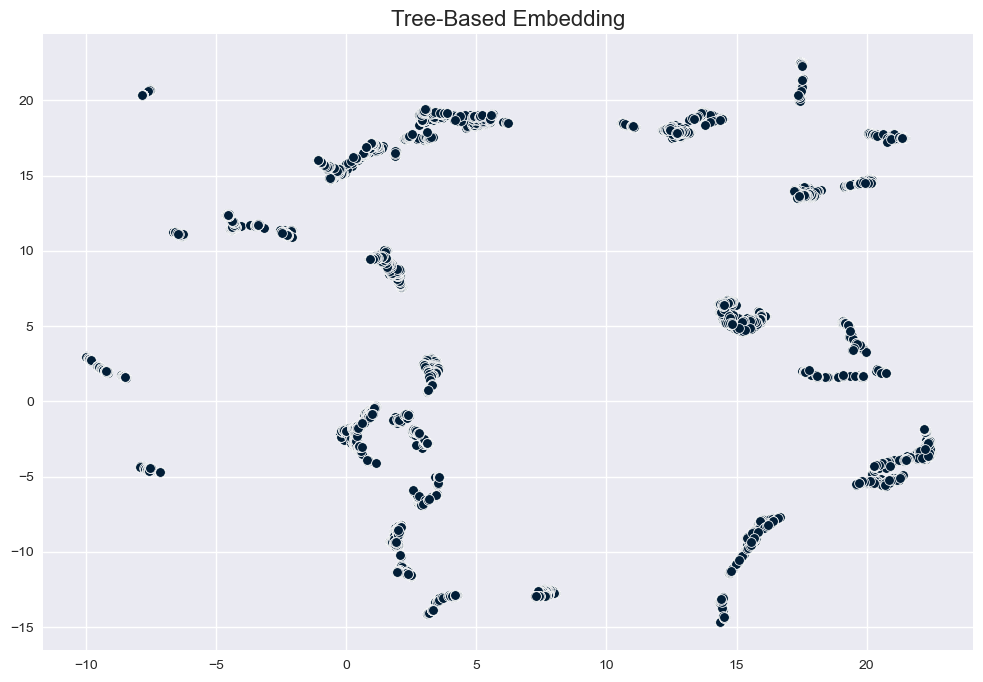

In [23]:
umap = um.UMAP(n_neighbors=50, random_state=42, n_jobs=-1, n_components=2, n_epochs=500)

#trans = umap.fit(df_leaf)
trans = pickle.load(open('../models/umap_reducer.pkl', 'rb'))

df_umap_rf = trans.transform(df_leaf)


df_embed_tree = pd.DataFrame(df_umap_rf)
plt.figure(figsize=(12, 8))

sns.scatterplot(x=df_umap_rf[:, 0], y=df_umap_rf[:, 1], color=facecolor)
plt.title('Tree-Based Embedding', fontsize=16);


In [75]:
#pickle.dump(trans, open('../models/umap_reducer.pkl', 'wb'))
#pickle.dump(umap, fs.open('s3://insider-data-bucket/umap_reducer.pkl', 'wb'))

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">8.0. Hyperparameter Fine-Tuning</h1>

</div>

In this section, we assess three models — k-means, Gaussian mixture and hierarchical clustering — using the silhouette score. For each model, we experiment multiple values of k (number of clusters) accross four different spaces: feature space, T-sne embedding, UMAP embedding, and tree-based embedding. We generate corresponding plots to visualize the results.

In [24]:
#X = df_fselect_sc.copy().reset_index(drop=True).drop(columns=['customer_id'])
# Using the data of the embedding space build with umap and a tree model

X = df_embed_sc.copy()

X_tree = df_embed_tree.copy()

X_umap = df_umap_sc.copy()

X_tsne = df_tsne_sc.copy()

## 8.1. K-Means

In [13]:
clusters = np.arange(2, 30, 1)

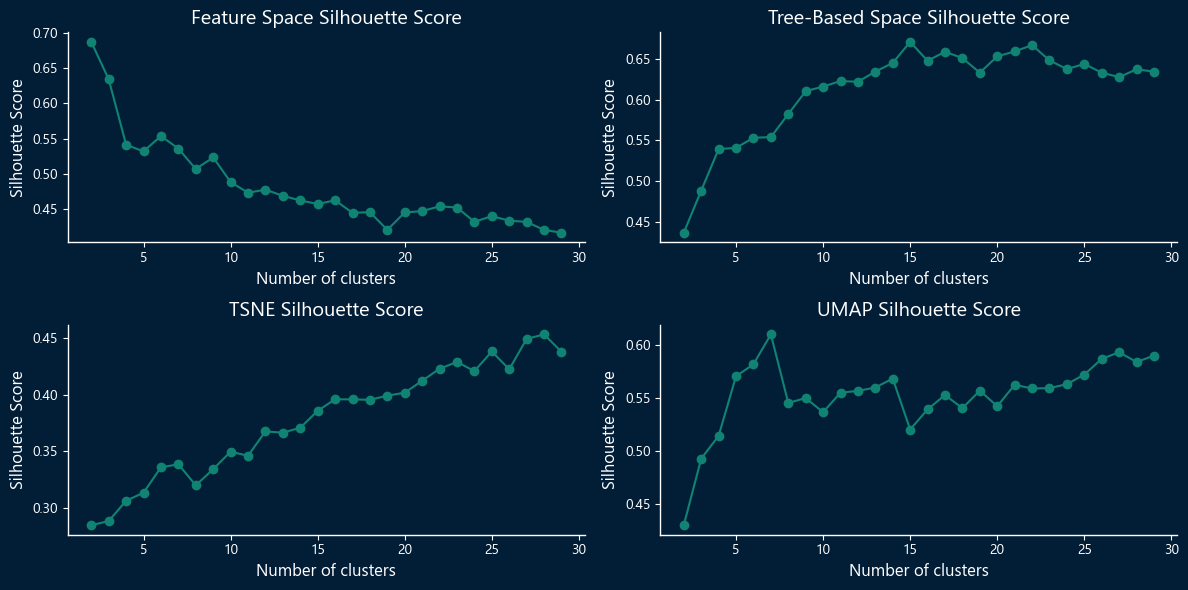

In [78]:
plt.figure(figsize=(12, 6), facecolor='#021e37')

plt.subplot(2, 2, 1)
gu.kmeans_performance(X=X, title='Feature Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 2)
gu.kmeans_performance(X=X_tree, title='Tree-Based Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 3)
gu.kmeans_performance(X=X_tsne, title='TSNE', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 4)
gu.kmeans_performance(X=X_umap, title='UMAP', clusters=clusters, metric='euclidean')
plt.tight_layout()

## 8.2 GMM

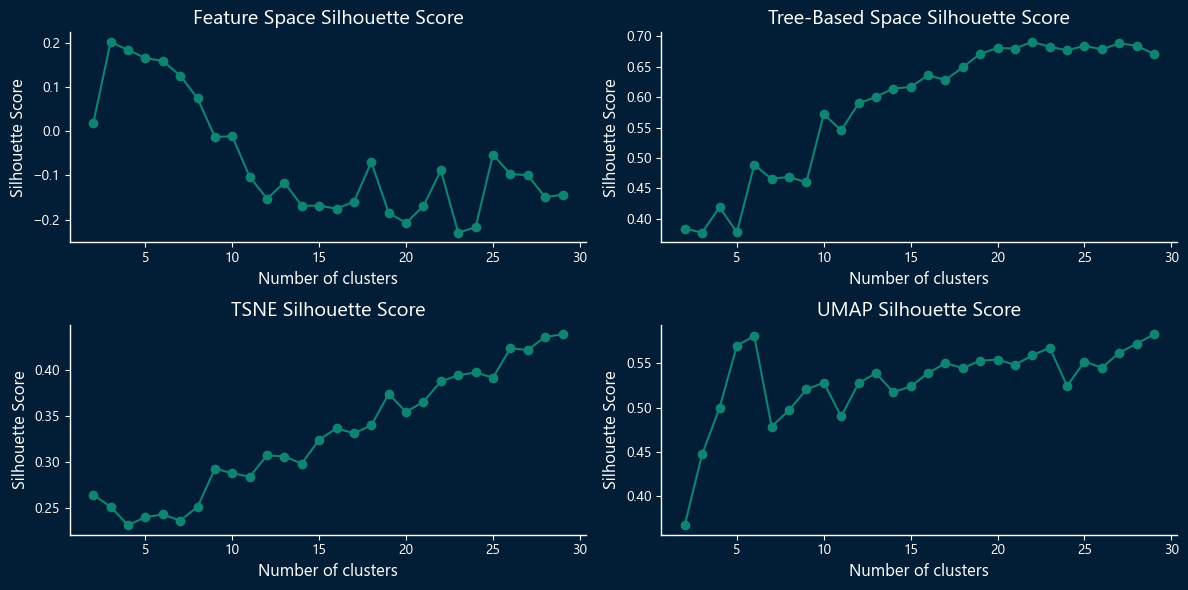

In [85]:
clusters = np.arange(2, 30, 1)

plt.figure(figsize=(12, 6), facecolor='#021e37')
plt.subplot(2, 2, 1)
gu.gmm_performance(X=X, title='Feature Space', components=clusters, metric='euclidean', covariance_type='full')
plt.subplot(2, 2, 2)
gu.gmm_performance(X=X_tree, title='Tree-Based Space', components=clusters, metric='euclidean', covariance_type='full')
plt.subplot(2, 2, 3)
gu.gmm_performance(X=X_tsne, title='TSNE', components=clusters, metric='euclidean', covariance_type='full')
plt.subplot(2, 2, 4)
gu.gmm_performance(X=X_umap, title='UMAP', components=clusters, metric='euclidean', covariance_type='full')
plt.tight_layout()

## 8.3 Hierarchical Custering

[]

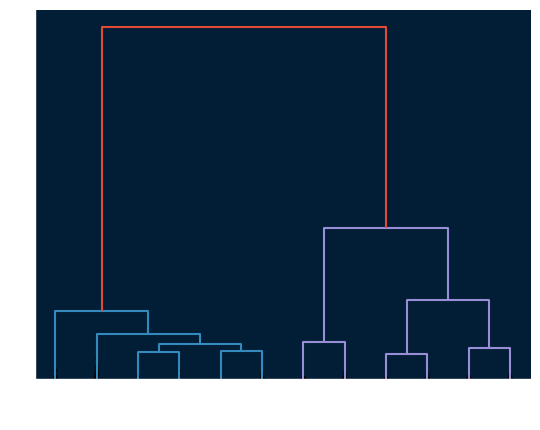

In [80]:
hc_model = linkage(X, 'ward')
dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
plt.plot()

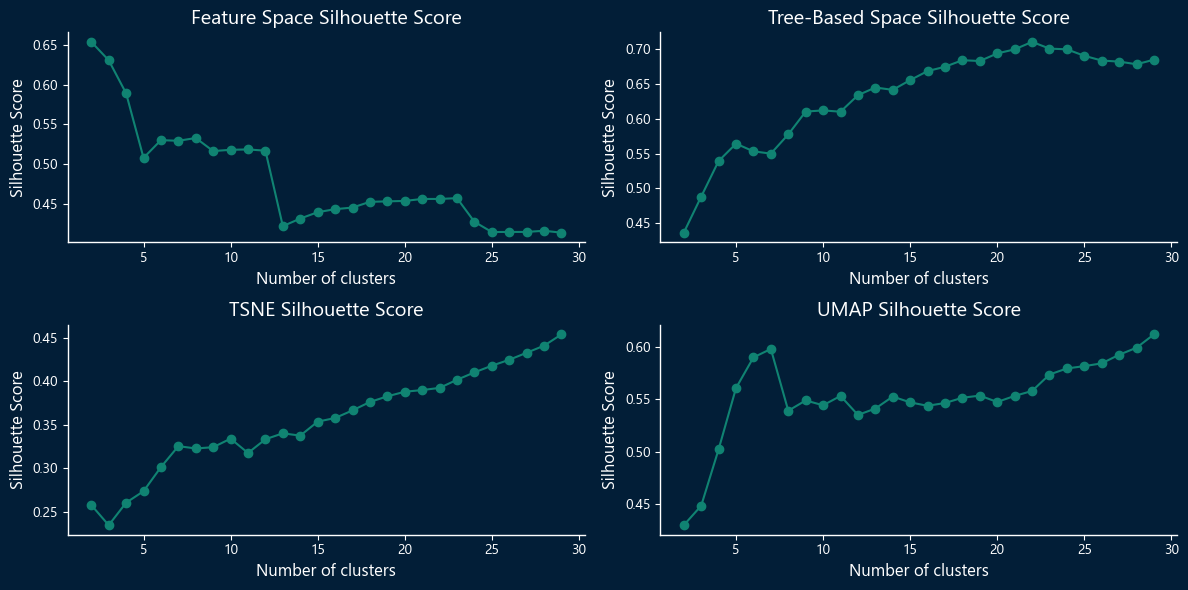

In [83]:
clusters = np.arange(2, 30, 1)

plt.figure(figsize=(12, 6), facecolor='#021e37')
plt.subplot(2, 2, 1)
gu.hierarchical_performance(X=X, title='Feature Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 2)
gu.hierarchical_performance(X=X_tree, title='Tree-Based Space', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 3)
gu.hierarchical_performance(X=X_tsne, title='TSNE', clusters=clusters, metric='euclidean')
plt.subplot(2, 2, 4)
gu.hierarchical_performance(X=X_umap, title='UMAP', clusters=clusters, metric='euclidean')
plt.tight_layout()

The tree-based space consistently produced the highest silhoutte scores for every model.

# Results

In [84]:
hierarch_perf = gu.hierarchical_performance(X=X_tree, clusters=clusters, plot=False, metric='euclidean')
gmm_perf = gu.gmm_performance(X=X_tree, components=clusters, plot=False, metric='euclidean', covariance_type='full')
kmeans_perf = gu.kmeans_performance(X=X_tree, clusters=clusters, plot=False, metric='euclidean')

results = pd.concat([kmeans_perf, hierarch_perf, gmm_perf])
results.columns = clusters

results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
KMeans,0.436470,0.488184,0.539213,0.540752,0.553104,0.553961,0.582279,0.610385,0.616100,0.622830,0.622001,0.634464,0.645111,0.671018,0.647756,0.658908,0.651056,0.633162,0.653193,0.659257,0.667010,0.648242,0.637514,0.643923,0.633100,0.627746,0.637281,0.634426
H_cluster,0.436470,0.488184,0.539213,0.564105,0.553104,0.549822,0.577405,0.610118,0.611800,0.609922,0.633605,0.644603,0.641257,0.655227,0.668184,0.674358,0.683758,0.682606,0.693504,0.699298,0.710051,0.700395,0.699359,0.690083,0.683273,0.681764,0.677953,0.684500
Gaussian Mixture,0.383819,0.376946,0.418997,0.377520,0.488402,0.465500,0.468688,0.459805,0.572222,0.545337,0.589542,0.600541,0.614181,0.616640,0.636078,0.628125,0.649100,0.671380,0.680780,0.679982,0.690944,0.682885,0.676970,0.684490,0.678574,0.688589,0.684556,0.671058


## Silhouette Analysis

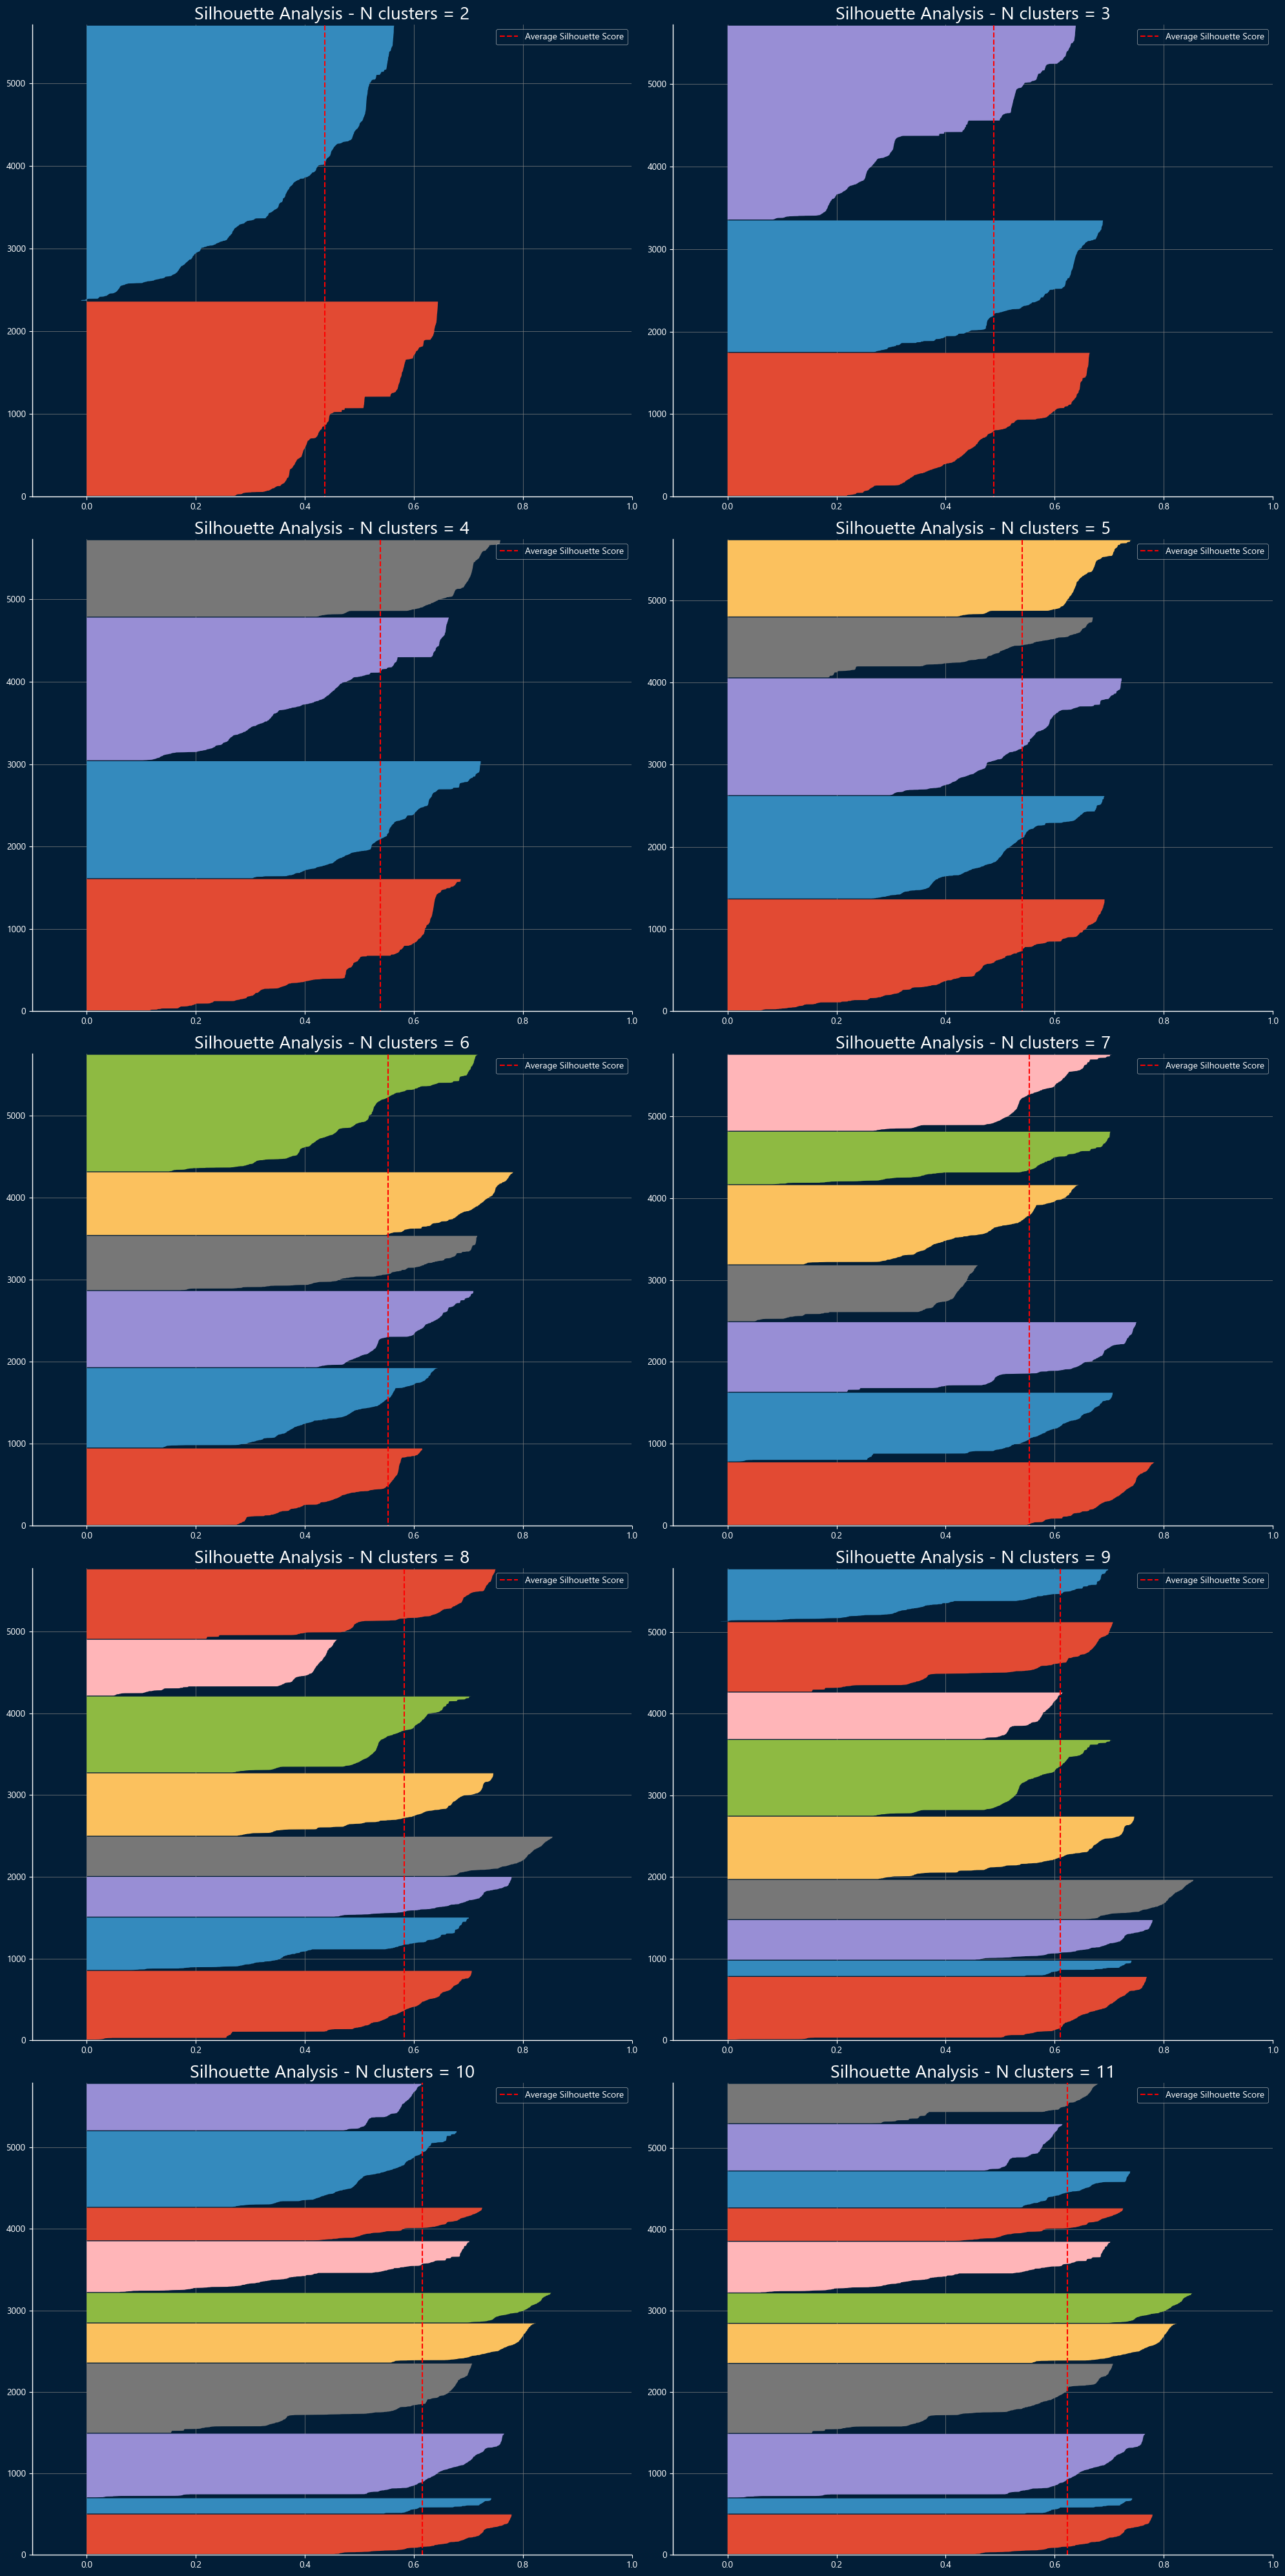

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(20, 40), facecolor='#021e37')
n_clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11,]
for k in n_clusters:

    # model
    #agg_clu = AgglomerativeClustering(n_clusters=k)
    #labels = agg_clu.fit_predict(X)
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    labels = kmeans.fit_predict(X_tree)

    q, mod = divmod(k, 2)
    #plt.rcParams['text.color'] = 'black'
    gu.silhouette_analysis(X_tree, labels, ax=ax[q-1, mod], k=k)

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">8.0. Model Training</h1>

</div>

## 8.1. Hierarchical Clustering

In [29]:
n_cluster = 10
kmeans = KMeans(init='random', n_clusters=n_cluster, n_init=10, max_iter=300, random_state=42 )

labels = kmeans.fit_predict(X_tree)

sil = mt.silhouette_score(X_tree, labels, metric='euclidean')

print(f'Silhouette Score: {sil}')

Silhouette Score: 0.6161004900932312


I iterated through this process multiple times to determine the appropriate algorithm and the number of clusters. I aimed to avoid having too many groups since it would be difficult to manage. 

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">9.0. Cluster Analysis</h1>

</div>

## 9.1. Visualization

In [20]:
gu.graph_config()

In [30]:
cluster_df = df_fselect.copy()
cluster_df_sc = df_fselect_sc.copy()
cluster_df['cluster'] = labels
cluster_df_sc['cluster'] = labels

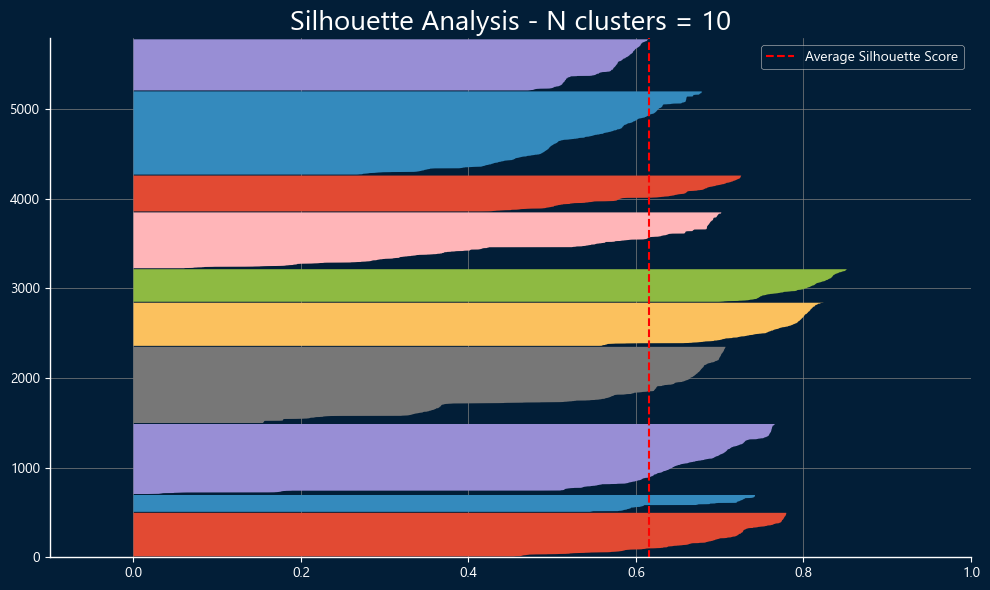

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='#021e37')
gu.silhouette_analysis(X_tree, labels, ax, n_cluster)

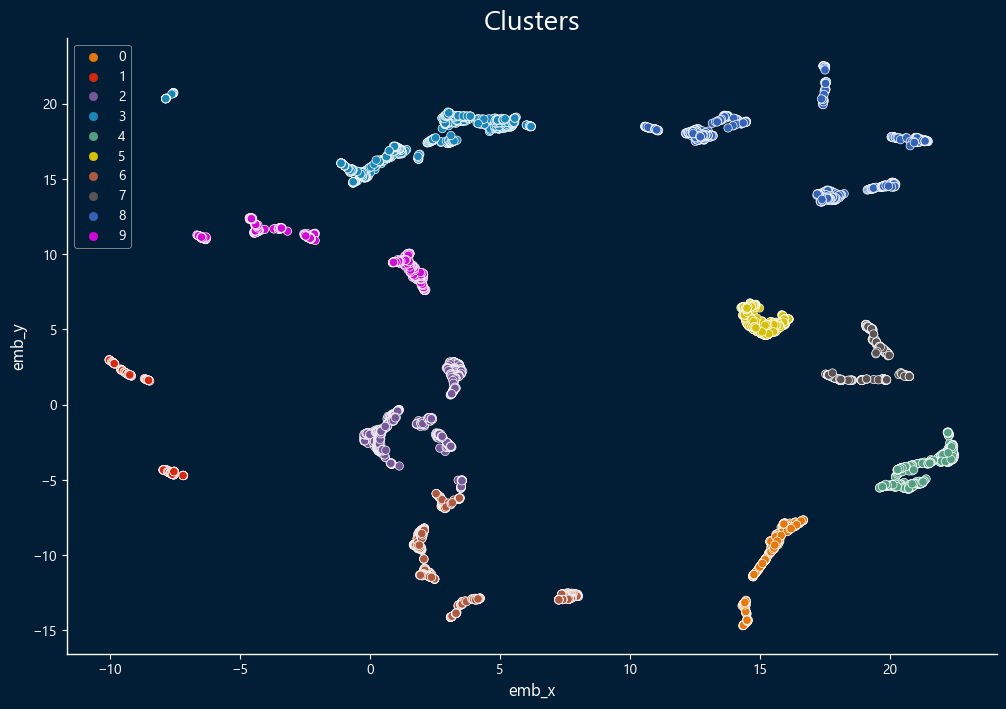

In [32]:
colors = ['#e6770b', '#d3290f', '#765898', '#1b85b8', '#559e83', '#D6C003', '#ae5a41', '#5a5255', '#3362b7', '#CD0AD5']

df_aux = df_embed_tree.copy()
df_aux.rename(columns={0: 'emb_x', 1: 'emb_y', 2: 'emb_z'}, inplace=True)
df_aux['cluster'] = labels
plt.figure(figsize=(12, 8), facecolor='#021e37')
ax = sns.scatterplot(x='emb_x', y='emb_y', hue='cluster', data=df_aux, palette=colors)
ax.legend(loc='upper left')
ax.grid(False)
ax.axes.set_facecolor('#021e37')
ax.set_xlabel('emb_x', color='white')
ax.set_ylabel('emb_y', color='white')
ax.set_title('Clusters', fontdict={'size': 20})

plt.show()

In [86]:
#df_aux['cluster'] = df_aux['cluster'].astype('object')
#px.scatter_3d(x='emb_x', y='emb_y', z='emb_z', data_frame=df_aux, color='cluster')

## 9.2. Clusters Profile

In [50]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index().rename(columns={'customer_id': 'number_of_customers'})
prof['percentual'] = round((cluster_df.groupby('cluster').count().reset_index()['customer_id']/cluster_df.shape[0])*100, 2)

prof['avg_recency'] = cluster_df.groupby('cluster').mean().reset_index()['recency']

prof['avg_frequency'] = cluster_df.groupby('cluster').mean().reset_index()['frequency']

prof['avg_spent'] = cluster_df.groupby('cluster').mean().reset_index()['total_spent']

prof['number_of_cancellations'] = cluster_df.groupby('cluster').mean().reset_index()['number_of_cancellations']

prof['avg_quantity'] = cluster_df.groupby('cluster').mean().reset_index()['total_quantity']


prof
prof.style.highlight_max(axis=0, subset=['avg_frequency',	'avg_spent', 'avg_quantity']).highlight_min(subset=['avg_recency', 'number_of_cancellations'], axis=0).set_table_styles([cell_hover, index_names, headers])

,cluster,number_of_customers,percentual,avg_recency,avg_frequency,avg_spent,number_of_cancellations,avg_quantity
0,0,487,8.570000,30.172485,0.052795,10708.476448,162.745380,6309.527721
1,1,189,3.330000,178.597884,0.018227,8.208095,0.000000,1.550265
2,2,782,13.770000,183.681586,0.013896,274.779156,0.930946,91.512788
3,3,851,14.980000,125.801410,0.018373,587.172456,6.065805,258.138660
4,4,482,8.490000,56.149378,0.029840,2771.582656,16.775934,1523.890041
5,5,364,6.410000,92.151099,0.013011,1484.395275,11.997253,755.623626
6,6,624,10.990000,192.171474,0.016260,89.819247,0.225962,24.331731
7,7,401,7.060000,47.673317,0.040373,1903.204065,13.690773,962.154613
8,8,929,16.360000,101.769645,0.019284,1050.478967,5.080732,470.316469
9,9,571,10.050000,123.022767,0.021182,350.855289,0.873905,164.488616


In [176]:
groups = ['insiders', 'not relevant',  'at risk', 'moderate', 'promising', 'good', 'hibernating', 'potential insiders', 'need attention', 'not promising']

I can't say the reason why the customers were grouped because they have similar attributes because the clusters were formed in an embedding space.

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">10. Exploratory Data Analysis</h1>

</div>

In [189]:
data_eda = cluster_df.copy()

clusters = prof.cluster.values
groups_dic = dict(zip(clusters, groups))

data_eda['groups'] = data_eda['cluster'].map(groups_dic)

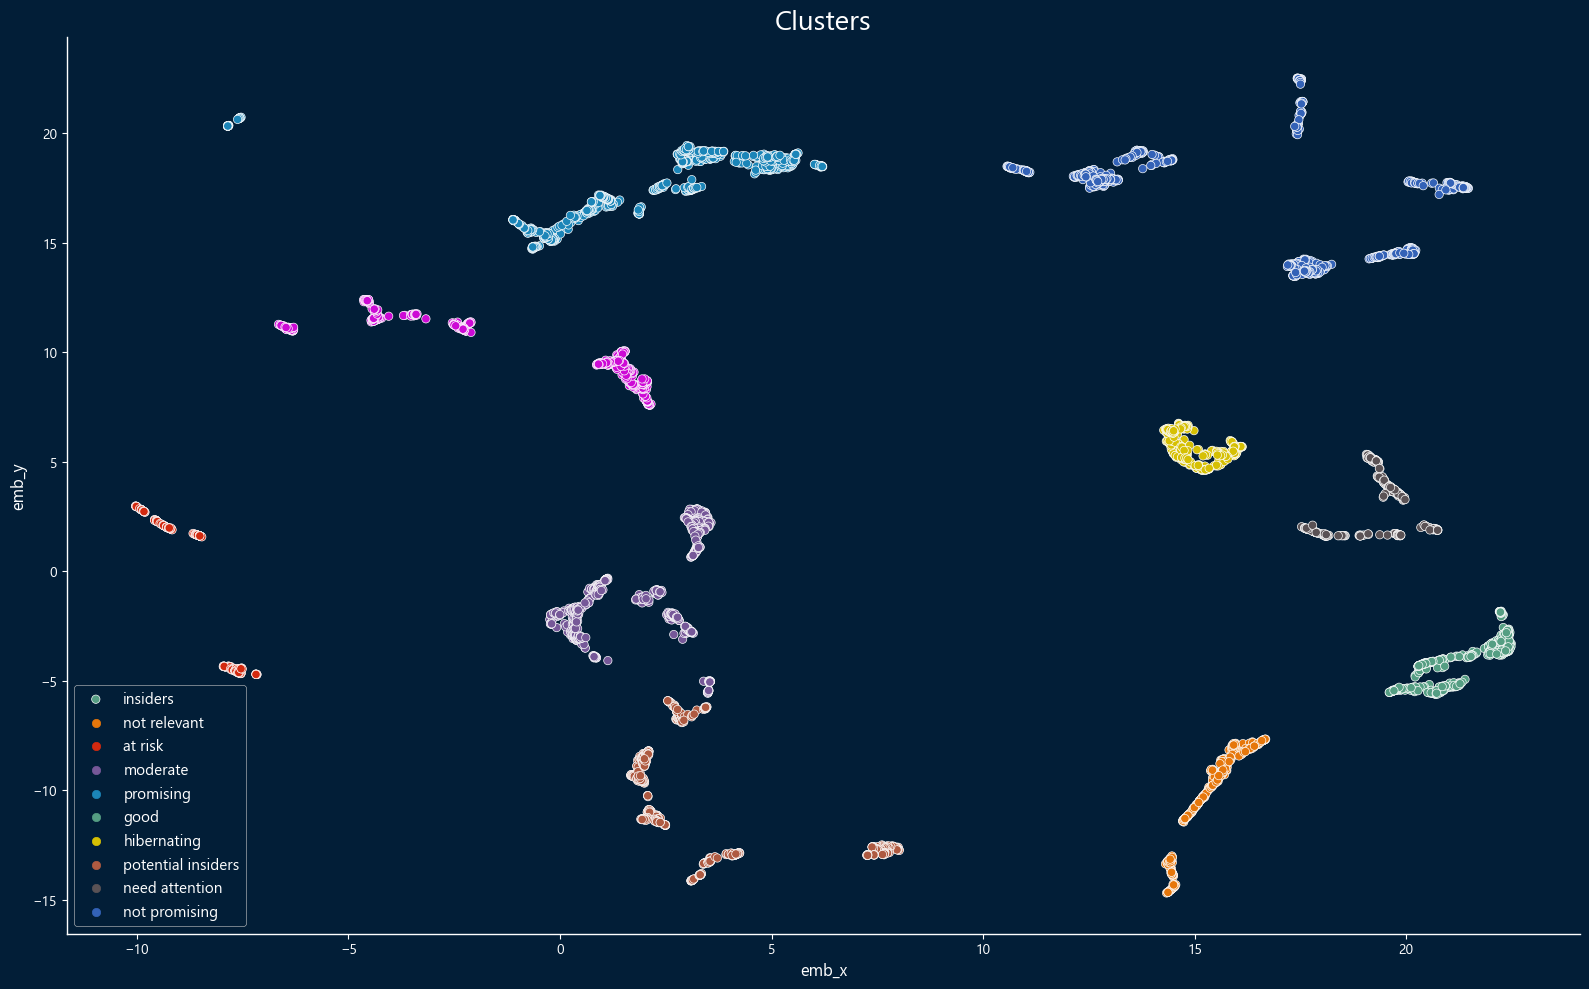

In [191]:
df_aux.rename(columns={0: 'emb_x', 1: 'emb_y', 2: 'emb_z'}, inplace=True)
df_aux['cluster'] = labels
plt.figure(figsize=(16, 10), facecolor='#021e37')
ax = sns.scatterplot(x='emb_x', y='emb_y', hue='cluster', data=df_aux, palette=colors)
ax.legend(groups, loc='lower left', fontsize=11)
ax.grid(False)
ax.axes.set_facecolor('#021e37')
ax.set_xlabel('emb_x', color='white')
ax.set_ylabel('emb_y', color='white')
ax.set_title('Clusters', fontdict={'size': 20})
plt.tight_layout()
plt.show()

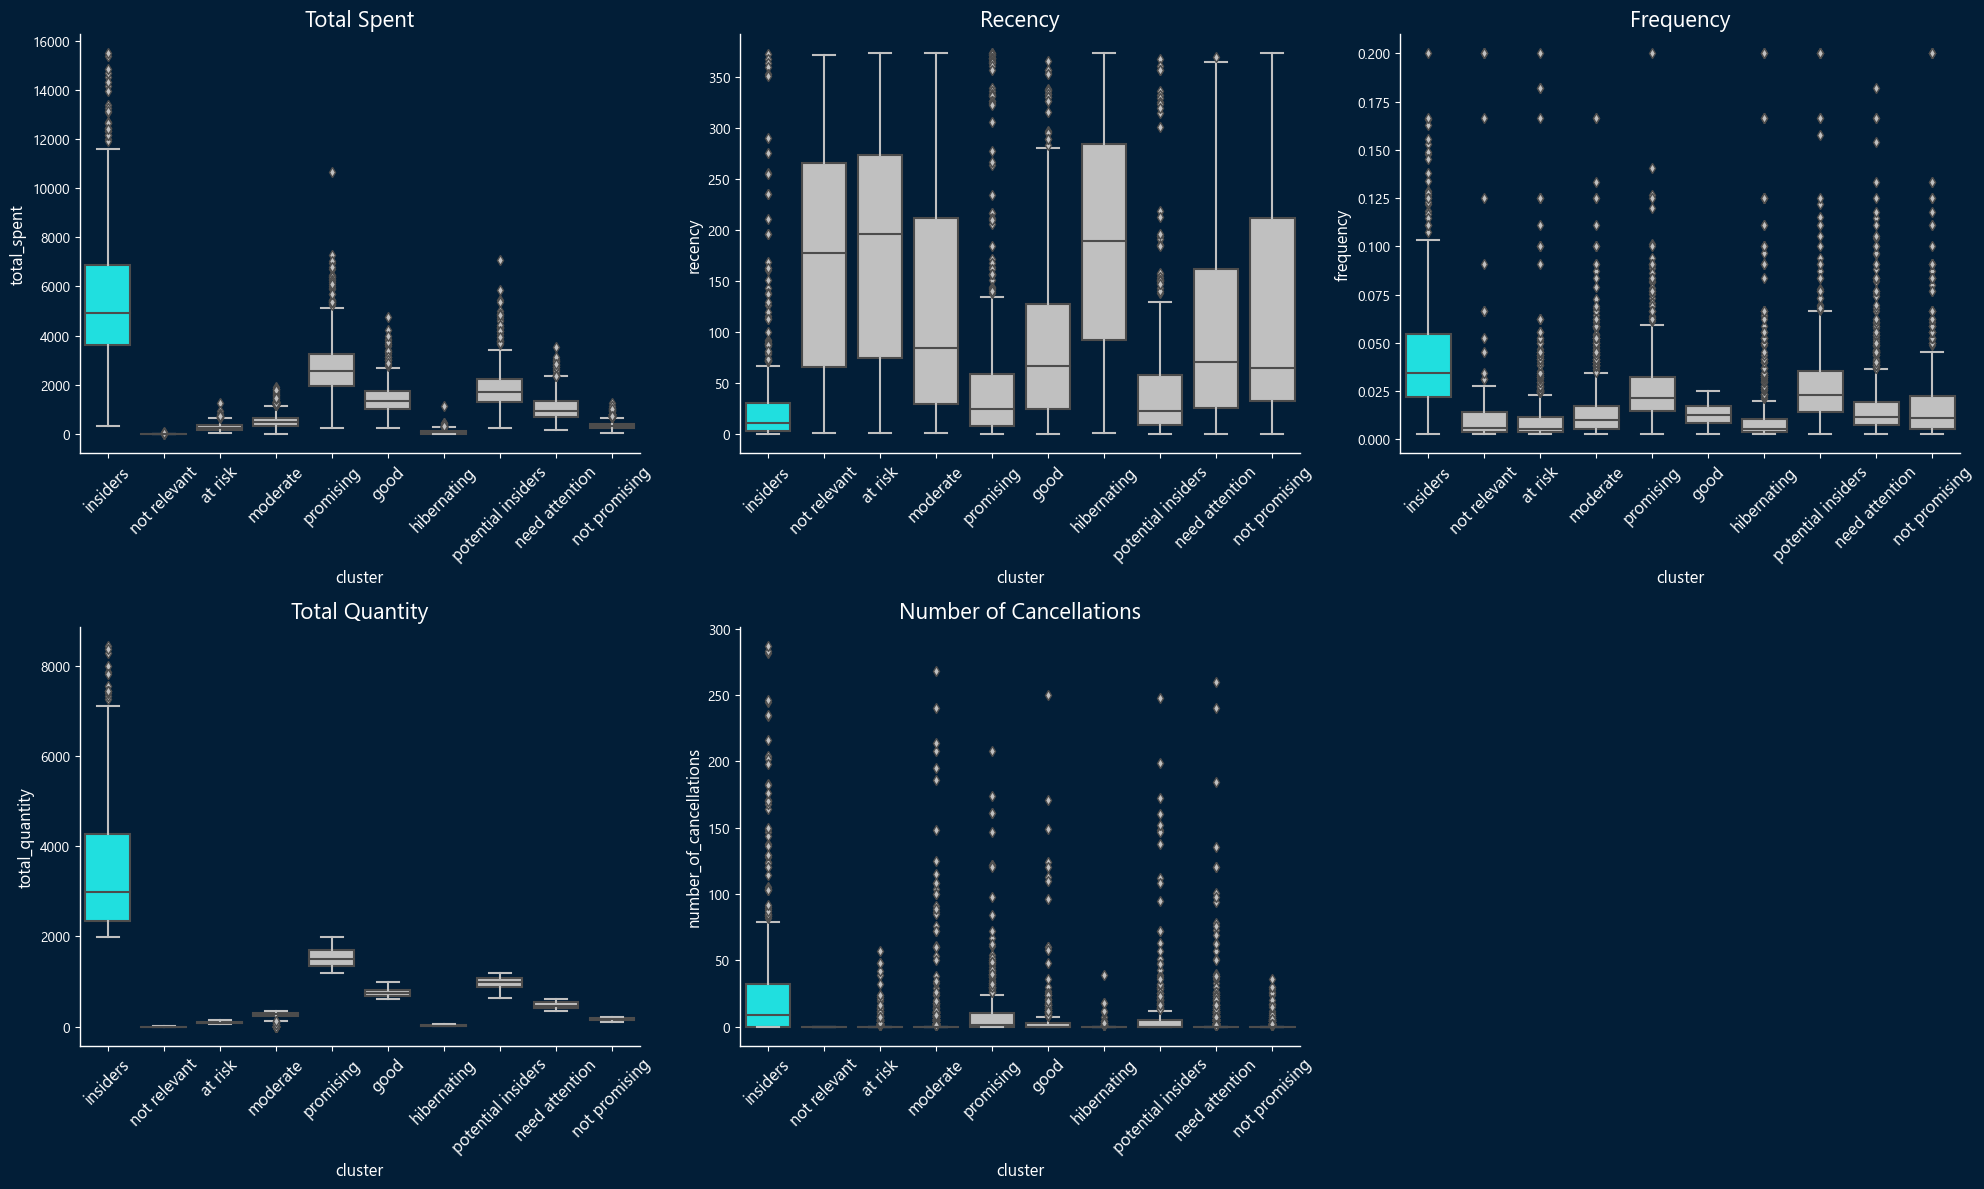

In [263]:
colors = ['aqua', 'silver', 'silver',  'silver', 'silver', 'silver', 'silver', 'silver', 'silver', 'silver']

whiskerprops={'color': 'silver'}
capprops={'color': 'silver'}
flierprops={"markerfacecolor": "silver"}

plt.figure(figsize=(20, 12), facecolor='#021e37')
#plt.style.use("dark_background")
plt.subplot(2, 3, 1)
plt.title('Total Spent', fontdict={'size': 16})
sns.boxplot(x='cluster', y='total_spent', data=data_eda.loc[data_eda.total_spent <= np.quantile(data_eda.total_spent, 0.99)], palette=colors, flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)
plt.xticks(ticks=clusters, labels=groups, rotation=45, fontdict={'size': 12})

plt.subplot(2, 3, 2)
plt.title('Recency', fontdict={'size': 16})
sns.boxplot(x='cluster', y='recency', data=data_eda, palette=colors, flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)
plt.xticks(ticks=clusters, labels=groups, rotation=45, fontdict={'size': 12})

plt.subplot(2, 3, 3)
plt.title('Frequency', fontdict={'size': 16})
sns.boxplot(x='cluster', y='frequency', data=data_eda.loc[data_eda.frequency <= np.quantile(data_eda.frequency, 0.99)], palette=colors, flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)

plt.xticks(ticks=clusters, labels=groups, rotation=45, fontdict={'size': 12})

plt.subplot(2, 3, 4)
plt.title('Total Quantity', fontdict={'size': 16})
sns.boxplot(x='cluster', y='total_quantity', data=data_eda.loc[data_eda.total_quantity <= np.quantile(data_eda.total_quantity, 0.99)], palette=colors, flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)
plt.xticks(ticks=clusters, labels=groups, rotation=45, fontdict={'size': 12})

plt.subplot(2, 3, 5)
plt.title('Number of Cancellations', fontdict={'size': 16})
sns.boxplot(x='cluster', y='number_of_cancellations', data=data_eda.loc[data_eda.number_of_cancellations <= np.quantile(data_eda.number_of_cancellations, 0.99)], palette=colors, flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)
plt.xticks(ticks=clusters, labels=groups, rotation=45, fontdict={'size': 12})
plt.tight_layout();

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 10.1. Hypothesis MindMap

<img src="../images/mind_map.png">

## 10.2. Business Hypothesis 

### Purchases

<s>1. The customers in the insiders group use a credit card as the paymennt method in 80% of their purchases.</s>

2. 60% of customers in the insiders group have a a higher variety of products in their purchase history than the general average.

3. The average ticket of the insiders group is 50% higher than the other groups.

4. 50% of the insiders have a frequency higher than 0.1.

5. The customers in the insiders group have a basket size bigger than 5 products.

**6. The volume of purchases of the insiders group represents 15% of the overall volume.**

**7. The insiders group of customers has a purchase cancellation rate that is 5% lower than the overall cancellation rate..**


<s>8. 5% of the customers in the insiders group receive more than U$ 100,000.00 annually.

### Product

<s>1. The customers in the insider group buy products with an above average price.</s>

2. 70% of the customers in the worst group buy products with a unit price lower than the overall average.

3. 30% of the products sold in big packages, of the whole dataset, are bought by customers in the insider group.** 

**4. The median price of the products bought by the customers in the insider group is 10% higher than the overall median.**

<s>5. The average weight of the products bought by the insider group is higher than the average weight product bought by the other clusters.</s>

### Customers

<s>1. The customers of the insider group are, o average, older than the customer of the other groups.</s>

<s>2. 60% of the insiders are at least undergraduates.</s>

<s>3. The top 100 highest spenders have a family with at least 4 members.</s>

<s>4. The insider group is composed of 60% of women.</s>

<s>5. The top 30 highest buyers of the insiders group live nearby the headquarters of the e-commerce.</s>

<s>6. 80% of the customers in the insider group are single.</s>

<s>7. 10% of the customer in the insider group are in the age range of 24-35 years.</s>

<s>8. 40% of the delivery address are in a radius of 50 km.

## 10.3. Hypothesis Validation

**H0:** The volume of purchases (quantity) made by the 'insiders' group of customers represents 15% or more of the overall volume of purchases.

The 'insiders' group is responsible for 57.91% of the quantities sold.


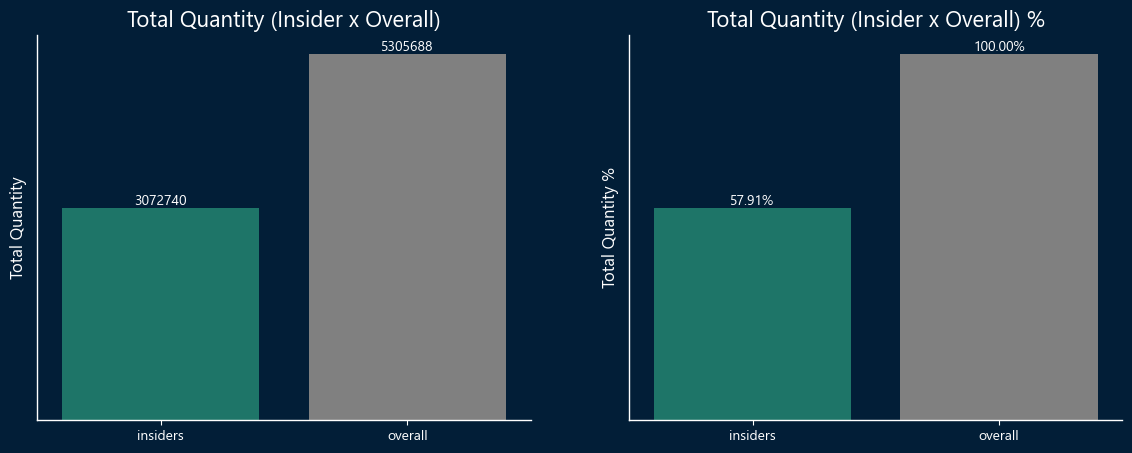

In [291]:
insider = data_eda.query('groups=="insiders"').total_quantity.sum()
overall = data_eda.total_quantity.sum()

insider_perc = round(insider/overall, 4)*100
overall_perc = 1*100

plt.figure(figsize=(14, 5), facecolor='#021e37')
plt.subplot(1, 2, 1)
plt.title('Total Quantity (Insider x Overall)', fontsize=16)
bar1 = sns.barplot(y=[insider, overall], x=['insiders', 'overall'], palette=['#108372', 'grey'])
plt.bar_label(bar1.containers[0], fmt="%d")
plt.ylabel('Total Quantity')
bar1.axes.set_yticks([])

plt.subplot(1, 2, 2)
plt.title('Total Quantity (Insider x Overall) %', fontsize=16)
bar2 = sns.barplot(y=[insider_perc, overall_perc], x=['insiders', 'overall'], palette=['#108372', 'grey']);
plt.bar_label(bar2.containers[0], fmt='%.2f%%')
bar2.axes.set_yticks([])
plt.ylabel('Total Quantity %')

print(f'The \'insiders\' group is responsible for {insider_perc}% of the quantities sold.')

**H1:** The average total spent by the customers of the 'insiders' group is 50% higher than the average total spent by customers in other groups.

In [282]:
df_aux = data_eda.copy()
df_aux['group_block'] = df_aux['groups'].apply(lambda x: x if x == 'insiders' else 'other')
df_aux = df_aux.groupby('group_block').mean(numeric_only=True).total_spent.reset_index()
per = round(((df_aux.iloc[0][1] - df_aux.iloc[1][1])/df_aux.iloc[1][1]), 4)

The Average total spent of the 'insiders' group is 1112.11% higher than the average of the other groups


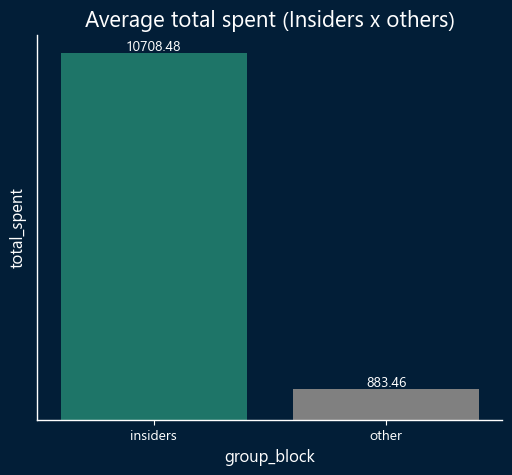

In [290]:
plt.figure(figsize=(6, 5), facecolor='#021e37')
bar = sns.barplot(x='group_block', y='total_spent', data=df_aux, palette=['#108372', 'grey'])
plt.title('Average total spent (Insiders x others)', fontsize=16)
bar.axes.set_yticks([])
plt.bar_label(bar.containers[0], fmt='%.2f');

print(f'The Average total spent of the \'insiders\' group is {per:.2%} higher than the average of the other groups')

**H2:** The revenue generated by the \'insiders\' group of customers represents 15% or more of the total revenue.

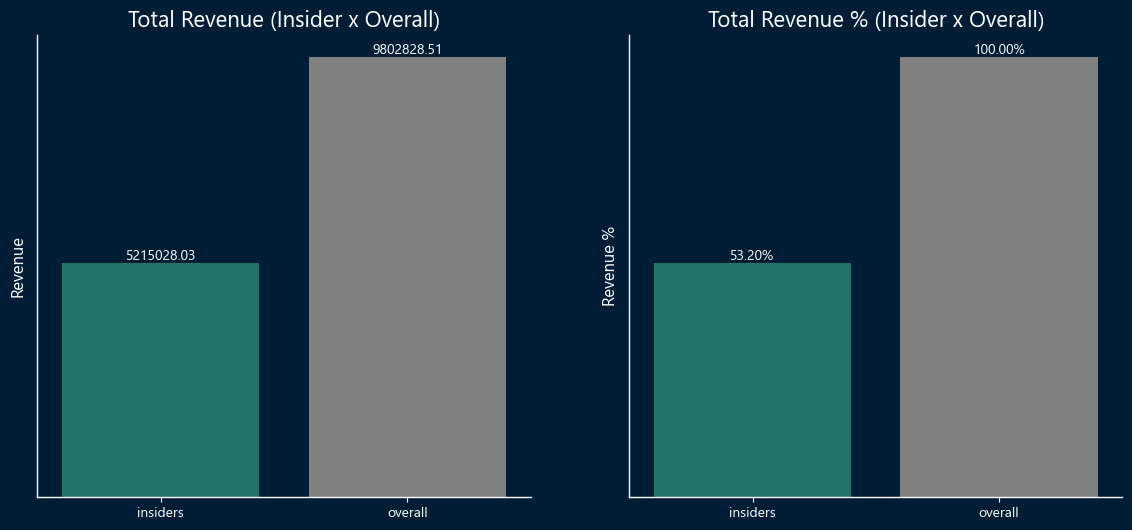

In [284]:
insider = data_eda.query('groups=="insiders"').total_spent.sum()
overall = data_eda.total_spent.sum()

insider_perc = round(insider/overall, 4)
overall_perc = 1

plt.figure(figsize=(14, 6), facecolor='#021e37')
plt.subplot(1, 2, 1)
plt.title('Total Revenue (Insider x Overall)', fontsize=16)
bar1 = sns.barplot(y=[insider, overall], x=['insiders', 'overall'], palette=['#108372', 'grey'])
bar1.axes.set_yticks([])
plt.ylabel('Revenue')
plt.bar_label(bar1.containers[0], fmt='%.2f')
plt.grid(False)


plt.subplot(1, 2, 2)
plt.title('Total Revenue % (Insider x Overall)', fontsize=16)
bar2 = sns.barplot(y=[insider_perc*100, overall_perc*100], x=['insiders', 'overall'], palette=['#108372', 'grey']);
bar2.axes.set_yticks([])
plt.ylabel('Revenue %')
plt.bar_label(bar2.containers[0], fmt='%.2f%%');
plt.grid(False)

In [288]:
print(f'TRUE: The \'insiders\' group is responsible for {insider_perc:.2%} of the sales.')

TRUE: The 'insiders' group is responsible for 53.20% of the sales.


**H3:** The insider group of customers has a purchase cancellation rate that is 5% lower than the overall cancellation rate.

The insider group cancellation rate is 26.49% lower than the overall average.


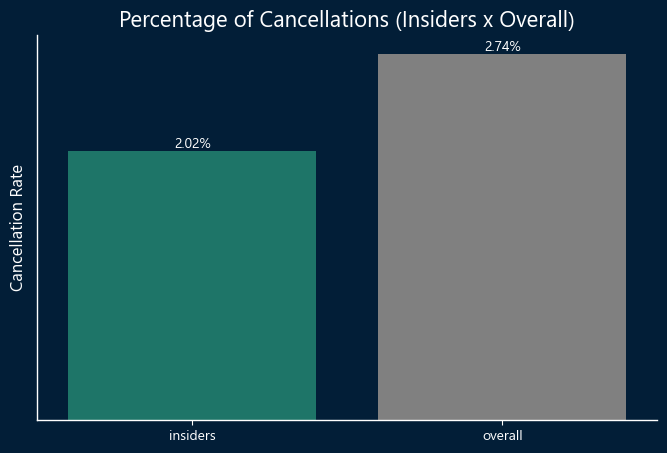

In [286]:
df_canc_by_quantity = data_eda.copy()
df_canc_by_quantity['cancellation_by_quantity'] = df_canc_by_quantity.number_of_cancellations/df_canc_by_quantity.total_quantity
insider = df_canc_by_quantity.query('groups=="insiders"').groupby('groups').mean(numeric_only=True).cancellation_by_quantity["insiders"]

overall = df_canc_by_quantity.mean(numeric_only=True).cancellation_by_quantity
perc = (insider - overall)/overall

plt.figure(figsize=(8, 5), facecolor='#021e37')
plt.title('Percentage of Cancellations (Insiders x Overall)', fontsize=16)
bar = sns.barplot(y=[insider*100, overall*100], x=['insiders', 'overall'], palette=['#108372', 'grey'])
bar.axes.set_yticks([])
plt.bar_label(bar.containers[0], fmt='%.2f%%')
plt.ylabel('Cancellation Rate');

print(f'The insider group cancellation rate is {abs(perc):.2%} lower than the overall average.')


In [201]:
#insider = cluster_df.query('cluster==0').groupby('cluster').mean().number_of_cancellations[0]
#
#overall = cluster_df.mean().number_of_cancellations
#perc = (insider - overall)/overall
#
#plt.figure(figsize=(8, 5))
#plt.title('Number of Cancellations (Isinder x Overall)', fontsize=10)
#bar = sns.barplot(y=[insider, overall], x=['insider', 'overall'], palette=['cadetblue', 'grey'])
#bar.axes.set_yticks([])
#plt.bar_label(bar.containers[0], fmt='%d')
#plt.ylabel('Cancellations')
#print(f'The average number of cancelations made by the insider group is {perc:.2%} higher than the overall average.')

**H04:** The median total spent by insiders is 30% higher than the overall median.

In [287]:
median_insider = data_eda.query('groups == "insiders"').total_spent.median()
overall_median = data_eda.total_spent.median()

perc_diff = (median_insider - overall_median)/overall_median

print(f'The median total spent of the group \'insiders\' is {perc_diff:.2%} higher than the overall median.')

The median total spent of the group 'insider' is 786.26% higher than the overall median.


**H05:** The customers in the insider group are concentrated in the 3° quantile of the monetary feature.

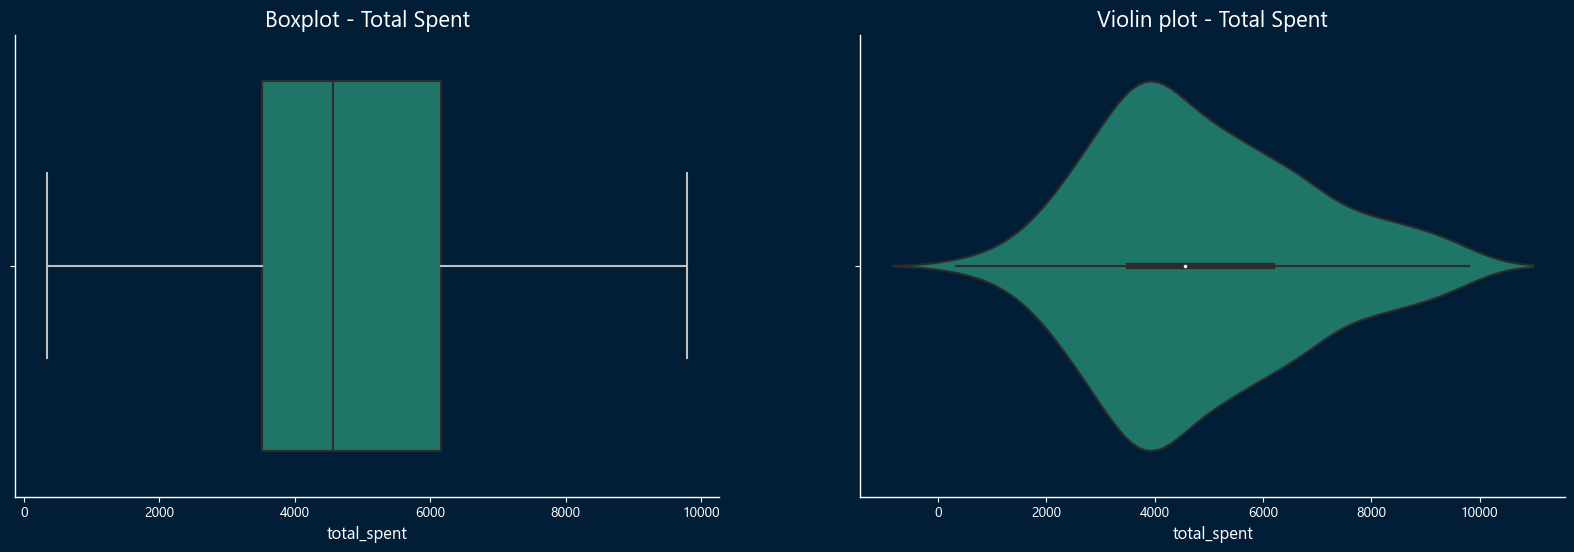

In [295]:
monetary = data_eda.query('groups == "insiders" & total_spent < 10000').total_spent

plt.figure(figsize=(20, 6), facecolor='#021e37')
plt.subplot(1, 2, 1)
sns.boxplot(x=monetary, color='#108372', flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)
plt.title('Boxplot - Total Spent', fontsize=16)

plt.subplot(1, 2, 2)
sns.violinplot(x=monetary, color='#108372', flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)
plt.title('Violin plot - Total Spent', fontsize=16);

The customers in the insider group are concentrated in the first quantile.

<div style = 'background-color:#021e37'>

<h2 style="text-align:center;padding:10px;color:white">Business Questions</h2>


</div>

### 1. Who are the customers eligible for the insider cluster?

In [296]:
insider_ids = data_eda.query('groups == "insiders"')[['customer_id']]
insider_ids.head(8)

,customer_id
2,12583
5,15291
6,14688
7,17809
8,15311
12,16029
14,12431
15,17511


In [297]:
#with open('../reports/table.md', 'w') as file:
#    file.write(insider_ids.to_markdown())
    

### 2. How many customers will be in the group?

In [298]:
number_of_customers = data_eda.query('groups == "insiders"')[['customer_id']].shape[0]

print(f'The insider group will have {number_of_customers} customers.')

The insider group will have 487 customers.


### 3. What are the main attributes of the customers in the insider group?

In [299]:
insiders = data_eda.query('groups == "insiders"').drop(['customer_id'], axis=1)
insiders_car = insiders.groupby('groups').mean(numeric_only=True).T.rename(columns={'insiders': 'average'})
insiders_car

groups,average
recency,30.172485
frequency,0.052795
total_spent,10708.476448
total_quantity,6309.527721
number_of_cancellations,162.745380
cluster,0.000000


In [300]:
insiders = data_eda.query('groups == "insiders"').drop(['customer_id', 'cluster'], axis=1)
insiders_car = insiders.groupby('groups').mean(numeric_only=True).T.rename(columns={'insiders': 'Average'})
conf_intervals = {}
for col in insiders.drop(columns={'groups'}).columns:

    conf_interval = st.t.interval(confidence=0.95,
                df=len(insiders)-1,
                loc=np.mean(insiders[col]),
                scale=st.sem(insiders[col]))
    
    conf_intervals[col] = conf_interval
    
insiders_car = pd.concat([insiders_car, pd.DataFrame(conf_intervals).T], axis=1) .rename(columns={0: 'LowerLimit', 1: 'UpperLimit'})

In [301]:
insiders_car

,Average,LowerLimit,UpperLimit
recency,30.172485,25.223354,35.121615
frequency,0.052795,0.045459,0.060132
total_spent,10708.476448,8651.853310,12765.099585
total_quantity,6309.527721,5167.639018,7451.416423
number_of_cancellations,162.745380,92.300627,233.190133


In [302]:
#insiders = cluster_df.query('cluster == 0').drop(['customer_id'], axis=1)
#insiders_car = insiders.groupby('cluster').median().T.rename(columns={5: 'Median'})
#conf_intervals = {}
#
#for col in insiders.drop('cluster', axis=1).columns:
#
#    conf_interval = st.bootstrap((insiders[col], ), statistic=np.median, n_resamples=len(insiders), method='basic').confidence_interval
#    
#    conf_intervals[col] = conf_interval
#    
#insiders_car = pd.concat([insiders_car, pd.DataFrame(conf_intervals).T], axis=1) .rename(columns={0: 'LowerLimit', 1: 'UpperLimit'})
#insiders_car

### 4. What is the share of the revenue that comes from the Insider group? 


In [303]:
insider = data_eda.query('groups == "insiders"').total_spent.sum()
overall = data_eda.total_spent.sum()

insider_perc = round(insider/overall, 4)
overall_perc = 1
print(f'The insider group is responsible for {insider_perc:.2%} of the revenue.')

The insider group is responsible for 53.20% of the revenue.


### 5. What are the requirements for a customer to be eligible for the Insiders group?

The model will decide who will be eligible for the insiders group.

### 6. What guarantees that the Insider program is better than the rest of the database?


The metrics of the insider group is better than the other groups.

### 7. What can the marketing team do to augment the revenue?

1. Offer a direct line to the best customers, improving the communication (anouncing products/services and promoting sales).
2. Drop off unprofitable customers (customers who only buy the discounted line and avoid premium range).
3. Personalized offers for each group.
4. Optimize marketing channels, identify the most effective marketing channels for each group.

<div style = 'background-color:#021e37'>

<h1 style="text-align:center;padding:10px;color:white">11. Deploy to Production</h1>

</div>

In [212]:
# adding the date of the last update of the model.
data_eda['last_training_time'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [213]:
import sqlite3
from sqlalchemy import create_engine

In [214]:
#query_delete_table = 'DROP TABLE insiders'
#con = sqlite3.connect('insiders_db.sqlite')
#con.execute(query_delete_table)
#con.commit()
#con.close()

In [215]:
query_create_table_insiders = """
    CREATE TABLE insiders(
        customer_id                 INTEGER,
        recency                     INTEGER,
        frequency                   REAL,
        total_spent                 REAL,
        total_quantity              INTEGER,
        number_of_cancellations     INTEGER,
        cluster                     INTEGER,
        groups                      TEXT,
        last_training_time          TEXT
        )"""

In [ ]:
# Database on  AWS
variables_env = dotenv.dotenv_values('../.env')

host = variables_env['HOST']
port = variables_env['PORT']
database =variables_env['DATABASE']
user=variables_env['USER']
pwd=variables_env['PASSWORD']

endpoint = f'postgresql://{user}:{pwd}@{host}/{database}:{port}'

engine = create_engine(endpoint)

con = engine.connect()
con.execute(query_create_table_insiders)

con.commit()

data_eda.to_sql('insiders', con=con, if_exists='append', index=False)
con.close()


In [216]:
#con = sqlite3.connect('insiders_db.sqlite')
#con.execute(query_create_table_insiders)
#con.commit()
#con.close()

# Insert Data
#engine = create_engine('sqlite:///insiders_db.sqlite')
#data_eda.to_sql('insiders', con=engine, if_exists='append', index=False)

5680